# Analyzing Transportation Patterns Using Chicago Taxi Trip and Chicago Rideshare for Urban Planning Insights

**Group Members**
1. Monika Phuengmak
2. Winni Tai 
3. Syeda Aqeel

## Table of Content
---
1. [Executive Summary](#1)
2. [Data Sources](#2)
3. [Data Cleaning](#3)
4. [Exploratory Data Analysis](#4)
5. [Hotspot Analysis](#5)
6. [Time Analysis](#6)
7. [Congestion Analysis](#7)
8. [Machine Learning](#8)
9. [Conclusion](#9)
10. [References and Generative AI Disclosure](#10)

## 1. Executive Summary <a class="anchor" id="1"></a>
---
### Problem Definition
This project aims to analyze Chicago’s taxi rides from 2018 to 2023 to generate actionable insights that support urban planning, enhance traffic management, and optimize transportation services. By identifying peak demand zones, assessing traffic congestion effects on trip durations, and analyzing fare trends across variables such as time, location, and service type, the project seeks to provide data-driven recommendations to improve mobility, reduce congestion, and better meet the transportation needs of Chicago’s residents and visitors.

### Motivation
Urban planning is an important aspect of designing cities to meet the infrastructure needed to support the livelihood of tens of millions of residents. Transportation in particular has a critical impact on people’s decision to accept employment, how they spend their time, places they visit, and even business locations. This exploration of Chicago taxi and ride share service data will provide an insight on traffic conditions, travel expenses, and hotspots for visitation in the city which can be used for city planning purposes. This exploration of Chicago taxi provides an insight on traffic conditions, travel expenses, and hotspots for visitation in the city which can be used for city planning purposes.

## 2. Data Sources <a class="anchor" id="2"></a>
---
- Chicago Taxi Trips from 2013 to 2023: [link](https://data.cityofchicago.org/Transportation/Taxi-Trips-2013-2023-/wrvz-psew/about_data)
- Chicago Community Area: [link](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6)

### Chicago Taxi Trips Data 2013-2023

This dataset reflects taxi trips reported to the City of Chicago in its role as a regulatory agency. To protect privacy but allow for aggregate analyses, the Taxi ID is consistent for any given taxi medallion number but does not show the number. Census Tracts are suppressed in some cases for privacy. Due to the data reporting process, not all trips are reported but the City believes that most are.

**Columns in this dataset**

|Column name|Description|Type|
|--|--|--|
|trip_id|A unique identifier for the trip. Initially called unique_key, but it will be renamed to trip_id.|String|
|taxi_id|A unique identifier for the taxi.|String|
|trip_start_timestamp|Date and time when the trip started, rounded to the nearest 15 minutes.|Timestamp|
|trip_end_timestamp|Date and time when the trip ended, rounded to the nearest 15 minutes.|Timestamp|
|trip_seconds|Duration of the trip in seconds.|Integer|
|trip_miles|Distance of the trip in miles.|Integer|
|pickup_census_tract|The Census Tract where the trip began. For privacy, this Census Tract is not shown for some trips. This column often will be blank for locations outside Chicago.|Number|
|dropoff_census_tract|The Census Tract where the trip ended. For privacy, this Census Tract is not shown for some trips. This column often will be blank for locations outside Chicago.|Number|
|pickup_community_area|The Community Area where the trip began. This column will be blank for locations outside Chicago.|Integer|
|dropoff_community_area|The Community Area where the trip ended. This column will be blank for locations outside Chicago.|Integer|
|fare|The fare for the trip.|Double|
|tips|The tip for the trip. Cash tips generally will not be recorded.|Double|
|tolls|The tolls for the trip.|Double|
|extras|Extra charges for the trip. This generally includes airport surcharges, late-night or rush hour surcharges, credit card processing fee, and other surcharges.|Double|
|trip_total|Total cost of the trip calculated from are, tips, tolls, and extras.|Double|
|payment_type|Type of payment for the trip.|String|
|company|The taxi company.|String|
|pickup_latitude|The latitude of the center of the pickup census tract or the community area if the census tract has been hidden for privacy. This column often will be blank for locations outside Chicago.|Double|
|pickup_longitude|The longitude of the center of the pickup census tract or the community area if the census tract has been hidden for privacy. This column often will be blank for locations outside Chicago.|Double|
|pickup_location|The location of the center of the pickup census tract or the community area if the census tract has been hidden for privacy. This column often will be blank for locations outside Chicago.|String|
|dropoff_latitude|The latitude of the center of the dropoff census tract or the community area if the census tract has been hidden for privacy. This column often will be blank for locations outside Chicago.|Double|
|dropoff_longitude|The longitude of the center of the dropoff census tract or the community area if the census tract has been hidden for privacy. This column often will be blank for locations outside Chicago.|Double|
|dropoff_location|The location of the center of the dropoff census tract or the community area if the census tract has been hidden for privacy. This column often will be blank for locations outside Chicago.|String|

### Chicago Community Area Data
Chicago City has 77 community areas in total. This dataset is used in conjunction with Chicago Taxi dataset to get the name of community area for pickup and dropoff location.

**Columns in this dataset**

|Column name|Description|Type|
|--|--|--|
|the_geom|Polygons that outline the geographic boundaries.|String|
|AREA_NUMBE|Community area number.|Integer|
|COMMUNITY|Community name.|String|
|AREA_NUM_1|Community area number. Duplicates of AREA_NUMBE.|Integer|

## 3. Data Cleaning <a class="anchor" id="3"></a>
---

In [1]:
from pyspark.sql.types import (StructType, 
                               StructField, 
                               DoubleType,
                               IntegerType,
                               StringType,
                               TimestampType)

from pyspark.sql.functions import year, col, round, sum, count

### Chicago Taxi Dataset

Download data from Google Cloud Bucket:

In [2]:
bucket = spark._jsc.hadoopConfiguration().get("fs.gs.system.bucket")

url = "gs://" + bucket + "/data/chicago-taxi-trip/chicago-taxi-0000000000*"

In [3]:
taxi_schema = StructType([StructField('trip_id', StringType(), True),
                StructField('taxi_id', StringType(), True),
                StructField('trip_start_timestamp', TimestampType(), True), 
                StructField('trip_end_timestamp', TimestampType(), True), 
                StructField('trip_seconds', IntegerType(), True), 
                StructField('trip_miles', DoubleType(), True), 
                StructField('pickup_census_tract', IntegerType(), True), 
                StructField('dropoff_census_tract', IntegerType(), True), 
                StructField('pickup_community_area', IntegerType(), True), 
                StructField('dropoff_community_area', IntegerType(), True), 
                StructField('fare', DoubleType(), True), 
                StructField('tips', DoubleType(), True), 
                StructField('tolls', DoubleType(), True), 
                StructField('extras', DoubleType(), True), 
                StructField('trip_total', DoubleType(), True), 
                StructField('payment_type', StringType(), True), 
                StructField('company', StringType(), True), 
                StructField('pickup_latitude', DoubleType(), True), 
                StructField('pickup_longitude', DoubleType(), True), 
                StructField('pickup_location', StringType(), True), 
                StructField('dropoff_latitude', DoubleType(), True), 
                StructField('dropoff_longitude', DoubleType(), True), 
                StructField('dropoff_location', StringType(), True)])

taxi_all_years = spark.read.format("csv").option("header", "true").schema(taxi_schema).csv(url)

In [4]:
taxi_all_years.printSchema()

root
 |-- trip_id: string (nullable = true)
 |-- taxi_id: string (nullable = true)
 |-- trip_start_timestamp: timestamp (nullable = true)
 |-- trip_end_timestamp: timestamp (nullable = true)
 |-- trip_seconds: integer (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- pickup_census_tract: integer (nullable = true)
 |-- dropoff_census_tract: integer (nullable = true)
 |-- pickup_community_area: integer (nullable = true)
 |-- dropoff_community_area: integer (nullable = true)
 |-- fare: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- extras: double (nullable = true)
 |-- trip_total: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- company: string (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_location: string (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = tru

In [5]:
taxi_all_years.count()

99667058

Inspect the first 10 rows of the dataset:

In [6]:
taxi_all_years.limit(10).toPandas()

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,5003bdd51918a9b5a52134096663b4d7e02395c5,2130bc5fd239a4e3b304662424fb4cc7db0ca7abf78cc5...,2013-02-25 14:15:00,2013-02-25 14:15:00,120,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,Cash,None,NaN,NaN,None,NaN,NaN,None
1,720534d264001b2644f682755b294067fdf1da21,4bb55b69e710d1792f5fd4888001f4ff0ce34040f976f8...,2013-06-02 08:15:00,2013-06-02 08:15:00,60,0.02,NaN,NaN,NaN,NaN,...,NaN,NaN,Cash,None,NaN,NaN,None,NaN,NaN,None
2,515b9a6d5234a4d1fb559dca27b3e1cc541a342d,4bb55b69e710d1792f5fd4888001f4ff0ce34040f976f8...,2013-06-24 06:15:00,2013-06-24 06:15:00,60,0.04,NaN,NaN,1.0,77.0,...,NaN,NaN,Cash,None,42.009623,-87.670167,POINT (-87.67016685690001 42.0096228806),41.986712,-87.663416,POINT (-87.6634164054 41.9867117999)
3,8afd48d966bf464e93127f43b72a8e405596a8eb,0150188f8c8e8973a198d4af0b427fca8ff48df2662d6b...,2013-02-01 07:00:00,2013-02-02 00:00:00,61560,0.00,NaN,NaN,NaN,NaN,...,0.0,0.0,Cash,None,NaN,NaN,None,NaN,NaN,None
4,fe73a44f01fdd2a3c740a01f53e97ec2ced93455,0150188f8c8e8973a198d4af0b427fca8ff48df2662d6b...,2013-02-01 07:00:00,2013-02-02 00:00:00,60900,0.00,NaN,NaN,NaN,NaN,...,0.0,0.0,Cash,None,NaN,NaN,None,NaN,NaN,None
5,e3f992b350122d006ab02bade16f0db85a77efad,0150188f8c8e8973a198d4af0b427fca8ff48df2662d6b...,2013-02-01 07:00:00,2013-02-02 00:00:00,60780,0.00,NaN,NaN,NaN,NaN,...,0.0,0.0,Cash,None,NaN,NaN,None,NaN,NaN,None
6,90e0d51d20f84ddbeece8c05a21ea031c8812a01,1f3593421771a4a6cc906137e5d3221ed2ab7bef3c2bfa...,2013-02-15 18:00:00,2013-02-15 18:00:00,0,0.00,NaN,NaN,NaN,NaN,...,0.0,0.0,Cash,None,NaN,NaN,None,NaN,NaN,None
7,ff4a3c7cd1bd70b906eb1ca91d620bfd215dd27e,1f3593421771a4a6cc906137e5d3221ed2ab7bef3c2bfa...,2013-02-15 18:00:00,2013-02-15 18:00:00,0,0.00,NaN,NaN,NaN,NaN,...,0.0,0.0,Cash,None,NaN,NaN,None,NaN,NaN,None
8,f927054758d789285e2ef73b21751e358bd5f64e,1f3593421771a4a6cc906137e5d3221ed2ab7bef3c2bfa...,2013-02-15 18:00:00,2013-02-15 18:00:00,60,0.10,NaN,NaN,NaN,NaN,...,0.0,0.0,Cash,None,NaN,NaN,None,NaN,NaN,None
9,95934109e937217408cc935b332e9ee3326b4875,842e2b1cd011fab01b6cc042f40c5941798405df1b3b02...,2013-02-17 06:00:00,2013-02-17 06:15:00,660,4.90,NaN,NaN,NaN,NaN,...,0.0,0.0,Cash,None,NaN,NaN,None,NaN,NaN,None


#### Filter only data between 2018 and 2023

In [7]:
start_year = (year(col("trip_start_timestamp")) >= 2018)
end_year = (year(col("trip_end_timestamp")) <= 2023)
taxi_trips = taxi_all_years.filter(start_year & end_year)

In [8]:
print(f"There are {taxi_trips.count()} taxi trips between 2013 and 2023")

There are 25347250 taxi trips between 2013 and 2023


#### Examine columns relating to travel duration and distance
Columns that we will use to estimate the traffic condition is trip_start_timestamp, trip_end_timestamp, trip_seconds, and trip_miles.

In [9]:
taxi_trips.select(
    count("*").alias("total_trip_count"),
    sum(col("trip_start_timestamp").isNull().cast("int")).alias("trip_start_timestamp_null_count"),
    sum(col("trip_end_timestamp").isNull().cast("int")).alias("trip_end_timestamp_null_count"),
    sum(col("trip_seconds").isNull().cast("int")).alias("trip_seconds_null_count"),
    sum(col("trip_miles").isNull().cast("int")).alias("trip_miles_null_count"),
).toPandas()

,total_trip_count,trip_start_timestamp_null_count,trip_end_timestamp_null_count,trip_seconds_null_count,trip_miles_null_count
0,25347250,0,0,4519,810


As we can see from the table above, very few rows are missing values in trip_seconds and trip_miles. We decide to drop rows with missing trip_miles and trip_seconds.

In [10]:
taxi_trips = taxi_trips.na.drop(subset=["trip_miles", "trip_seconds"])

In [11]:
taxi_trips.select(
    sum(col("trip_miles").isNull().cast("int")).alias("trip_miles_null_count"),
    sum(col("trip_seconds").isNull().cast("int")).alias("trip_seconds_null_count"),
).toPandas()

,trip_miles_null_count,trip_seconds_null_count
0,0,0


In [12]:
taxi_trips.select("trip_seconds").describe().show()

+-------+------------------+
|summary|      trip_seconds|
+-------+------------------+
|  count|          25341923|
|   mean|1015.9937619966724|
| stddev|1674.7307472738783|
|    min|                 0|
|    max|             86400|
+-------+------------------+



In [13]:
taxi_trips.select("trip_miles").describe().show()

+-------+-----------------+
|summary|       trip_miles|
+-------+-----------------+
|  count|         25341923|
|   mean| 4.90238553719892|
| stddev|7.482142116336658|
|    min|              0.0|
|    max|          3430.53|
+-------+-----------------+



#### Filter rows where the `trip_seconds` is too short
Some rows has trip second that doesn't last more than 1 minute, which we found unlikely for a taxi trip to be that short. We think that this is most likely due to mistakes in data reporting, meter errors, or some other factors which does not reflect the taxi services or demands such as cancelled rides and ride reassignment. We decide to use 60 seconds as a threshold where any trip under 60 seconds is considered to be an error in data collection or edge cases.

In [14]:
taxi_trips = taxi_trips.where(col("trip_seconds") >= 60)

#### Convert the the unit for trip duration from seconds to minute
Second isn't the usual unit we would use to describe a trip duration. We will use minute instead considering that it is not as granular as second, and a taxi trip rarely goes over an hour. Any reminder from calculating the minute will be rounded to the nearest minute.

In [15]:
taxi_trips = taxi_trips.withColumn("trip_minutes", round(col("trip_seconds") / 60).cast(IntegerType())).drop("trip_seconds")

#### Dropping pickup_census_tract and dropoff_census_tract
These 2 columns contains a lot of missing data that is purposely left blank for privacy. As you can see from the dataframe below, more than half of pickup_census_tract and dropoff_census_tract are missing. Because of this, as well as the size of a census track that is too granular a scale for our purpose, we will drop the census tract columns. pickup_community_area and dropoff_community_area which is more populated will be used as an indicator for locations in Chicago during analysis, while pickup_location and dropoff_location, which is the latitude and longitude of the location will be used in machine learning model to predict the duration of a trip in the later section.

In [16]:
taxi_trips.select(
    count("*").alias("total_trip_count"),
    sum(col("pickup_census_tract").isNull().cast("int")).alias("pickup_census_tract_null_count"),
    sum(col("dropoff_census_tract").isNull().cast("int")).alias("dropoff_census_tract_null_count"),
    sum(col("pickup_community_area").isNull().cast("int")).alias("pickup_community_area_null_count"),
    sum(col("dropoff_community_area").isNull().cast("int")).alias("dropoff_community_area_null_count"),
    sum(col("pickup_location").isNull().cast("int")).alias("pickup_location_null_count"),
    sum(col("dropoff_location").isNull().cast("int")).alias("dropoff_location_null_count"),
).toPandas()

,total_trip_count,pickup_census_tract_null_count,dropoff_census_tract_null_count,pickup_community_area_null_count,dropoff_community_area_null_count,pickup_location_null_count,dropoff_location_null_count
0,23973207,23973207,23973207,2704960,3200118,2702856,3106268


In [17]:
taxi_trips = taxi_trips.drop("pickup_census_tract", "dropoff_census_tract")

#### Pickup and Dropoff Locations
The columns that contain latitude, longitude, and location of pickup and dropoff is based off of the center of community area if the census tract is hidden. Considering that much of the census tract columns are missing, most of these columns can be replaced with community area. We'll also drop pickup_latitude, pickup_longitude, pickup_location, dropoff_latitude, dropoff_longitude, and dropoff_location.

In [18]:
taxi_trips = taxi_trips.drop("pickup_latitude", "pickup_longitude", "pickup_location", "dropoff_latitude", "dropoff_longitude", "dropoff_location")

#### Replace `NULL` community area columns with -1
Since the missing value in pickup_community_area and dropoff_community_area means that the location is outside of Chicago, not that the data is actually missing, we will replace it with a value -1 instead.

In [19]:
taxi_trips = taxi_trips.fillna({"pickup_community_area": -1, "dropoff_community_area": -1})

#### Examine columns related to payment

In [20]:
taxi_trips.select(
    count("*").alias("total_trip_count"),
    sum(col("fare").isNull().cast("int")).alias("fare_null_count"),
    sum(col("tips").isNull().cast("int")).alias("tips_null_count"),
    sum(col("tolls").isNull().cast("int")).alias("tolls_null_count"),
    sum(col("extras").isNull().cast("int")).alias("extras_null_count"),
    sum(col("trip_total").isNull().cast("int")).alias("trip_total_null_count"),
).toPandas()

,total_trip_count,fare_null_count,tips_null_count,tolls_null_count,extras_null_count,trip_total_null_count
0,23973207,7535,7535,3942469,7535,7535


The column tips, tolls, and extra will be left as null since it is possible for the ride to not incur such cost, but drop the row where fare or trip_total is missing.

In [21]:
taxi_trips = taxi_trips.na.drop(subset=["fare", "trip_total"])

In [22]:
taxi_trips.select(
    sum(col("fare").isNull().cast("int")).alias("fare_null_count"),
    sum(col("trip_total").isNull().cast("int")).alias("trip_total_null_count"),
).toPandas()

,fare_null_count,trip_total_null_count
0,0,0


In [23]:
taxi_trips.printSchema()

root
 |-- trip_id: string (nullable = true)
 |-- taxi_id: string (nullable = true)
 |-- trip_start_timestamp: timestamp (nullable = true)
 |-- trip_end_timestamp: timestamp (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- pickup_community_area: integer (nullable = false)
 |-- dropoff_community_area: integer (nullable = false)
 |-- fare: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- extras: double (nullable = true)
 |-- trip_total: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- company: string (nullable = true)
 |-- trip_minutes: integer (nullable = true)



#### Cache `taxi_trips` dataframe

In [24]:
taxi_trips.cache()

DataFrame[trip_id: string, taxi_id: string, trip_start_timestamp: timestamp, trip_end_timestamp: timestamp, trip_miles: double, pickup_community_area: int, dropoff_community_area: int, fare: double, tips: double, tolls: double, extras: double, trip_total: double, payment_type: string, company: string, trip_minutes: int]

#### Save cleaned dataframe to Google Cloud Storage for easy use

In [27]:
"""
# Only run this cell when saving the clean dataset to GCS
gcs_path = "gs://" + bucket + "/data/cleaned-data-2018-2023/taxi"

taxi_trips.write.option("header", "true").csv(gcs_path)
"""

'\n# Only run this cell when saving the clean dataset to GCS\ngcs_path = "gs://" + bucket + "/data/cleaned-data-2018-2023/taxi"\n\ntaxi_trips.write.option("header", "true").csv(gcs_path)\n'

### Community Area Dataset

In [28]:
community_area_schema = StructType([StructField('the_geom', StringType(), True), 
                                    StructField('PERIMETER', StringType(), True), 
                                    StructField('AREA', StringType(), True), 
                                    StructField('COMAREA_', StringType(), True), 
                                    StructField('COMAREA_ID', StringType(), True), 
                                    StructField('AREA_NUMBE', IntegerType(), True), 
                                    StructField('COMMUNITY', StringType(), True), 
                                    StructField('AREA_NUM_1', IntegerType(), True), 
                                    StructField('SHAPE_AREA', StringType(), True), 
                                    StructField('SHAPE_LEN', StringType(), True)])

community_areas = spark.read.format("csv").option("header", "true").schema(community_area_schema).csv("gs://qstba843-team2/data/chicago-taxi-trip/community_area.csv")

In [29]:
community_areas.limit(5).toPandas()

,the_geom,PERIMETER,AREA,COMAREA_,COMAREA_ID,AREA_NUMBE,COMMUNITY,AREA_NUM_1,SHAPE_AREA,SHAPE_LEN
0,MULTIPOLYGON (((-87.60914087617894 41.84469250...,0,0,0,0,35,DOUGLAS,35,46004621.1581,31027.0545098
1,MULTIPOLYGON (((-87.59215283879394 41.81692934...,0,0,0,0,36,OAKLAND,36,16913961.0408,19565.5061533
2,MULTIPOLYGON (((-87.62879823733725 41.80189303...,0,0,0,0,37,FULLER PARK,37,19916704.8692,25339.0897503
3,MULTIPOLYGON (((-87.6067081256125 41.816813770...,0,0,0,0,38,GRAND BOULEVARD,38,48492503.1554,28196.8371573
4,MULTIPOLYGON (((-87.59215283879394 41.81692934...,0,0,0,0,39,KENWOOD,39,29071741.9283,23325.1679062


#### Drop columns with missing values and duplicate values
All rows of `PERIMETER`, `AREA`, `COMAREA_`, and `COMAREA_ID` columns contains the same value 0, which implies that the data is missing, so there is no use to them. `AREA_NUM_1` column is a duplicte of `AREA_NUM` column. We will drop these 5 columns.

In [30]:
community_areas.select("PERIMETER").distinct().show()
community_areas.select("AREA").distinct().show()
community_areas.select("COMAREA_").distinct().show()
community_areas.select("COMAREA_ID").distinct().show()

+---------+
|PERIMETER|
+---------+
|        0|
+---------+

+----+
|AREA|
+----+
|   0|
+----+

+--------+
|COMAREA_|
+--------+
|       0|
+--------+

+----------+
|COMAREA_ID|
+----------+
|         0|
+----------+



In [31]:
community_areas = community_areas.drop("PERIMETER", "AREA", "COMAREA_", "COMAREA_ID", "AREA_NUM_1")

#### Add a row to indicate a placeholder community area outside of Chicago

In [32]:
from pyspark.sql import Row

community_areas = community_areas.union(spark.createDataFrame([Row(the_geom=None, AREA_NUMBE=-1, COMMUNITY="Outside of Chicago", SHAPE_AREA=None, SHAPE_LEN=None)], schema=community_areas.schema))

In [33]:
community_areas.where(col("AREA_NUMBE") == -1).toPandas()

,the_geom,AREA_NUMBE,COMMUNITY,SHAPE_AREA,SHAPE_LEN
0,None,-1,Outside of Chicago,None,None


#### Rename column AREA_NUMBE to AREA_NUMBER

In [34]:
community_areas = community_areas.withColumnRenamed("AREA_NUMBE", "AREA_NUMBER")

In [35]:
community_areas.printSchema()

root
 |-- the_geom: string (nullable = true)
 |-- AREA_NUMBER: integer (nullable = true)
 |-- COMMUNITY: string (nullable = true)
 |-- SHAPE_AREA: string (nullable = true)
 |-- SHAPE_LEN: string (nullable = true)



#### Cache `community_areas` dataframe

In [36]:
community_areas.cache()

DataFrame[the_geom: string, AREA_NUMBER: int, COMMUNITY: string, SHAPE_AREA: string, SHAPE_LEN: string]

#### Save cleaned dataframe to Google Cloud Storage for easy use

In [37]:
"""
# Only run this cell when saving the clean dataset to GCS
gcs_path = "gs://" + bucket + "/data/cleaned-data-2018-2023/community-area"

community_areas.write.option("header", "true").csv(gcs_path)
"""

'\n# Only run this cell when saving the clean dataset to GCS\ngcs_path = "gs://" + bucket + "/data/cleaned-data-2018-2023/community-area"\n\ncommunity_areas.write.option("header", "true").csv(gcs_path)\n'

## 4. Exploratory Data Analysis <a class="anchor" id="4"></a>
---

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [39]:
cleaned_taxi_url = "gs://" + bucket + "/data/cleaned-data-2018-2023/taxi/*.csv"

cleaned_taxi_schema = StructType([
                StructField('trip_id', StringType(), True),
                StructField('taxi_id', StringType(), True),
                StructField('trip_start_timestamp', TimestampType(), True), 
                StructField('trip_end_timestamp', TimestampType(), True), 
                StructField('trip_miles', DoubleType(), True), 
                StructField('pickup_community_area', IntegerType(), True), 
                StructField('dropoff_community_area', IntegerType(), True), 
                StructField('fare', DoubleType(), True), 
                StructField('tips', DoubleType(), True), 
                StructField('tolls', DoubleType(), True), 
                StructField('extras', DoubleType(), True), 
                StructField('trip_total', DoubleType(), True), 
                StructField('payment_type', StringType(), True), 
                StructField('company', StringType(), True),
                StructField('trip_minutes', IntegerType(), True)
])

taxi_trips = spark.read.format("csv").option("header", "true").schema(cleaned_taxi_schema).csv(cleaned_taxi_url)

In [40]:
cleaned_community_area_url = "gs://" + bucket + "/data/cleaned-data-2018-2023/community-area/*.csv"

cleaned_community_area_schema = StructType([StructField('the_geom', StringType(), True), 
                                    StructField('AREA_NUMBER', IntegerType(), True), 
                                    StructField('COMMUNITY', StringType(), True), 
                                    StructField('SHAPE_AREA', StringType(), True), 
                                    StructField('SHAPE_LEN', StringType(), True)])

community_areas = spark.read.format("csv").option("header", "true").schema(cleaned_community_area_schema).csv(cleaned_community_area_url)

In [41]:
taxi_trips.printSchema()

root
 |-- trip_id: string (nullable = true)
 |-- taxi_id: string (nullable = true)
 |-- trip_start_timestamp: timestamp (nullable = true)
 |-- trip_end_timestamp: timestamp (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- pickup_community_area: integer (nullable = true)
 |-- dropoff_community_area: integer (nullable = true)
 |-- fare: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- extras: double (nullable = true)
 |-- trip_total: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- company: string (nullable = true)
 |-- trip_minutes: integer (nullable = true)



In [42]:
community_areas.printSchema()

root
 |-- the_geom: string (nullable = true)
 |-- AREA_NUMBER: integer (nullable = true)
 |-- COMMUNITY: string (nullable = true)
 |-- SHAPE_AREA: string (nullable = true)
 |-- SHAPE_LEN: string (nullable = true)



In [43]:
taxi_trips.cache()

DataFrame[trip_id: string, taxi_id: string, trip_start_timestamp: timestamp, trip_end_timestamp: timestamp, trip_miles: double, pickup_community_area: int, dropoff_community_area: int, fare: double, tips: double, tolls: double, extras: double, trip_total: double, payment_type: string, company: string, trip_minutes: int]

In [44]:
community_areas.cache()

DataFrame[the_geom: string, AREA_NUMBER: int, COMMUNITY: string, SHAPE_AREA: string, SHAPE_LEN: string]

### 4.1 What is the distribution of trip duration?

In [45]:
taxi_trips_minutes_df = taxi_trips.select(col("trip_minutes")).toPandas()["trip_minutes"]

Because of the outlier in trip duration when it is large, it is hard to visually see the distribution of the majority of the trip duration data. We can see, however, that most of the trips is under 100 minutes, so we will examine the distribution of trip duration that's under 100 minutes.

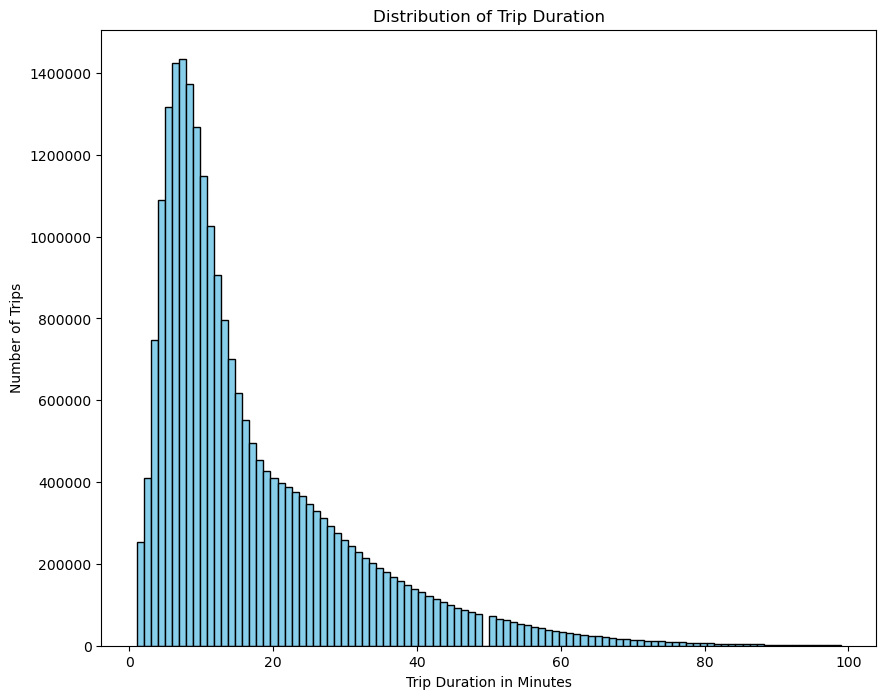

In [46]:
plt.figure(figsize=(10, 8))
plt.hist(taxi_trips_minutes_df[taxi_trips_minutes_df < 100], bins=100, color="skyblue", edgecolor="black")
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel("Trip Duration in Minutes")
plt.ylabel("Number of Trips")
plt.title("Distribution of Trip Duration")
plt.show()

In [47]:
pd.options.display.float_format = '{:.2f}'.format
taxi_trips_minutes_df.describe()

count   23965672.00
mean          17.89
std           28.40
min            1.00
25%            7.00
50%           12.00
75%           23.00
max         1440.00
Name: trip_minutes, dtype: float64

**Summary:** The distribution of taxi trip duration is right-skewed. Most trips are between 1 and 23 minutes. The median duration is 12 minutes but the mean duration is 17.89 minutes, suggesting most trips take a short time but some large outliers are pulling up the mean.

### 4.2 What is the distribution of trip distance?

In [48]:
taxi_trips_distance_df = taxi_trips.select(col("trip_miles")).toPandas()["trip_miles"]

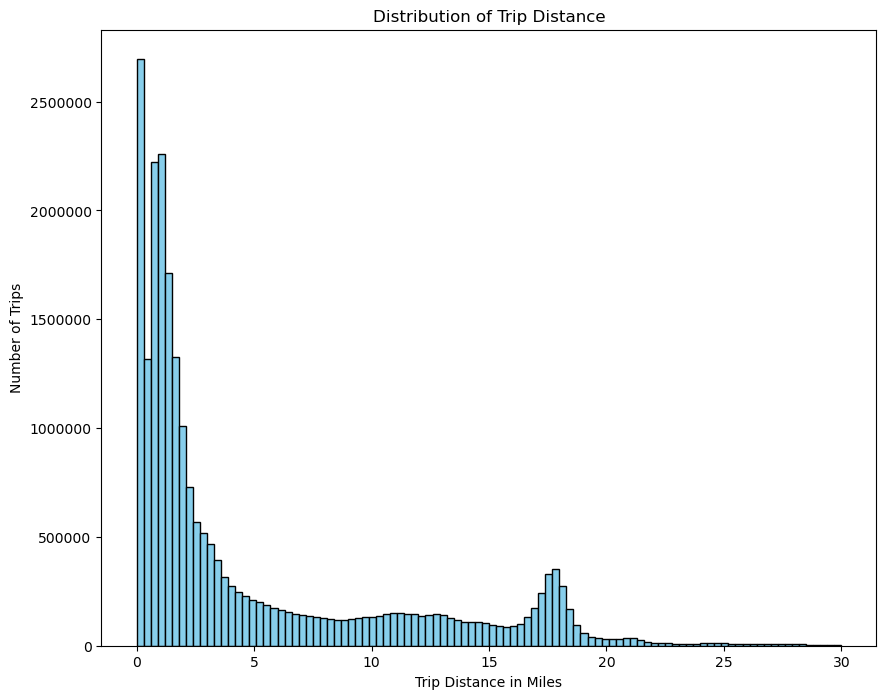

In [49]:
plt.figure(figsize=(10, 8))
plt.hist(taxi_trips_distance_df[taxi_trips_distance_df < 30], bins=100, color="skyblue", edgecolor="black")
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel("Trip Distance in Miles")
plt.ylabel("Number of Trips")
plt.title("Distribution of Trip Distance")
plt.show()

In [50]:
taxi_trips_distance_df.describe()

count   23965672.00
mean           5.17
std            7.45
min            0.00
25%            0.81
50%            1.90
75%            7.89
max         3430.53
Name: trip_miles, dtype: float64

**Summary:** The distribution for taxi trip distance is right-skewed. At least 50% of the total trip having a distance less than 2 miles, while mean distance is 5.17 miles, suggesting that there are many shot trips and a smaller number of very long trips pulling the mean upward. There is a small local manimum at around 16 to 20 miles, which may indicate inter-city trips where the pickup or dropoff location is outside of Chicago which result in longer trips.

### 4.3 What is the distribution of trip fare?

In [93]:
taxi_trips_fare_df = taxi_trips.select(col("fare")).toPandas()["fare"]

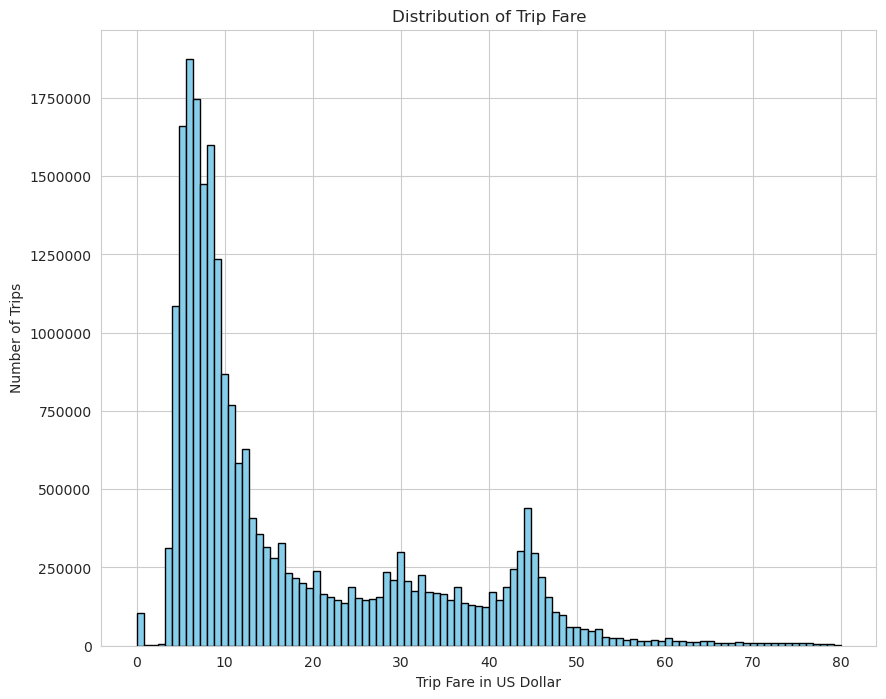

In [94]:
plt.figure(figsize=(10, 8))
plt.hist(taxi_trips_fare_df[taxi_trips_fare_df < 80], bins=100, color="skyblue", edgecolor="black")
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel("Trip Fare in US Dollar")
plt.ylabel("Number of Trips")
plt.title("Distribution of Trip Fare")
plt.show()

In [95]:
taxi_trips_fare_df.describe()

count   23965672.00
mean          18.34
std           55.45
min            0.00
25%            6.75
50%           10.50
75%           27.25
max         9900.26
Name: fare, dtype: float64

**Summary:** The distribution of fares for Chicago taxi trip is right-skewed. The majority of trips cost between 0 USD (indicatng that the trip may have been cancelled) and 28 USD. The median fare is 10.50 USD while the mean fare is 18.34 USD, suggesting that most trips cost somewhere around 10.50 USD but there are smaller of trips with more expensive fares that are pulling up the average. This may indicate a longer trip (for example, inter-city trip), as we also see in the trip distance distribution graph.

### 4.4 How does the number of taxi rides, taxi cars, and taxi companies changes across the years from 2018 to 2023?

We deem the trip start year to be the grouping factor for counting taxi cars in each year. Trips whose start year and end year is different (e.g. trips on New Year's Eve) will be counted to the start year.

In [96]:
from pyspark.sql.functions import year, countDistinct

df_with_year = taxi_trips.withColumn("year", year(taxi_trips["trip_start_timestamp"]))

trip_count_per_year = (
    df_with_year.groupBy("year")                      
                 .agg(countDistinct("trip_id").alias("unique_trip_count"))
                 .orderBy("year", ascending=True)
)

taxi_count_per_year = (
    df_with_year.groupBy("year")                      
                 .agg(countDistinct("taxi_id").alias("unique_taxi_count"))
                 .orderBy("year", ascending=True)
)

company_count_per_year = (
    df_with_year.groupBy("year")                      
                 .agg(countDistinct("company").alias("unique_company_count"))
                 .orderBy("year", ascending=True)
)

In [97]:
trip_count_per_year_pd = trip_count_per_year.toPandas()
taxi_count_per_year_pd = taxi_count_per_year.toPandas()
company_count_per_year_pd = company_count_per_year.toPandas()

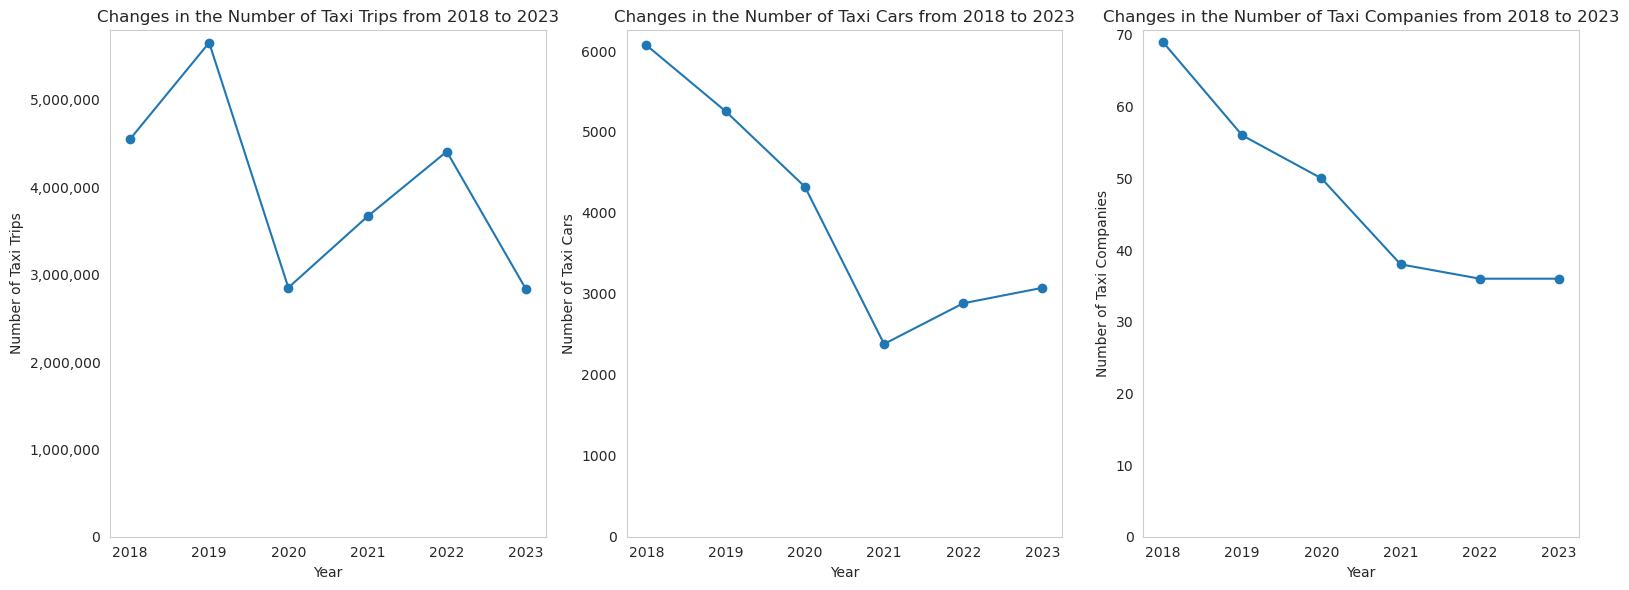

In [98]:
from matplotlib.ticker import StrMethodFormatter

fig, axes = plt.subplots(1, 3, figsize=(16,6), sharey=False)

axes[0].plot(trip_count_per_year_pd["year"], trip_count_per_year_pd["unique_trip_count"], marker='o', linestyle='-')
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Number of Taxi Trips")
axes[0].set_title("Changes in the Number of Taxi Trips from 2018 to 2023")
axes[0].set_ylim(bottom=0)
axes[0].yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
axes[0].grid()

axes[1].plot(taxi_count_per_year_pd["year"], taxi_count_per_year_pd["unique_taxi_count"], marker='o', linestyle='-')
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Number of Taxi Cars")
axes[1].set_title("Changes in the Number of Taxi Cars from 2018 to 2023")
axes[1].set_ylim(bottom=0) 
axes[1].grid()

axes[2].plot(company_count_per_year_pd["year"], company_count_per_year_pd["unique_company_count"], marker='o', linestyle='-')
axes[2].set_xlabel("Year")
axes[2].set_ylabel("Number of Taxi Companies")
axes[2].set_title("Changes in the Number of Taxi Companies from 2018 to 2023")
axes[2].set_ylim(bottom=0) 
axes[2].grid()

plt.tight_layout()
plt.show()

**Summary:** The graphs above compare the trends of taxi trips, taxi cars, and taxi companies over time. We can see that the number of taxi cars and taxi companies following similr trends where it continue to decrease from 2019 to 2021, which the trends for taxi trip counts is less predictable. The first case of COVID-19 is recorded at the beginning of 2020, followed by strict travel restrictions and statewide stay-at-home order in the state of Illinois that extends through May 2020 and stay-at-home advisory from November 2020 through December 2020 significantly affects the taxi trip demands, which explains the sharp drop from 2019 to 2020. The trip demands, however, makes a turnaround in 2021 and continue to increase in 2022 after the restriction is lifted and COVID-19 policy shift toward vacination, although it doesn't recover to the same height as in 2019 before COVID-19. The number of taxi cars and companies drops in 2020 also continue to decrease even after the restriction is lifted, which is possibly due to taxi drivers switching careers after experiencing poor demand in the previous years and competitions from Rideshare apps. Taxi companies may have shut down due to profit loss and industry's unsustainability in the face of Rideshare app's rising popularity.

### 4.5 What is the correlation between duration and distance of taxi trips?

In [99]:
taxi_trips_miles_minutes = taxi_trips[['trip_miles', 'trip_minutes']]

In [100]:
taxi_trips_miles_minutes = taxi_trips_miles_minutes.na.drop(subset=['trip_miles'])
df_miles_minutes = taxi_trips_miles_minutes.toPandas()
df_miles_minutes = df_miles_minutes[(df_miles_minutes["trip_miles"] > 0) & (df_miles_minutes["trip_miles"] <= 100)]

In [101]:
correlation = df_miles_minutes['trip_minutes'].corr(df_miles_minutes['trip_miles'])
print(f"Correlation between trip duration and trip distance is {correlation:.2f}.")

Correlation between trip duration and trip distance is 0.42.


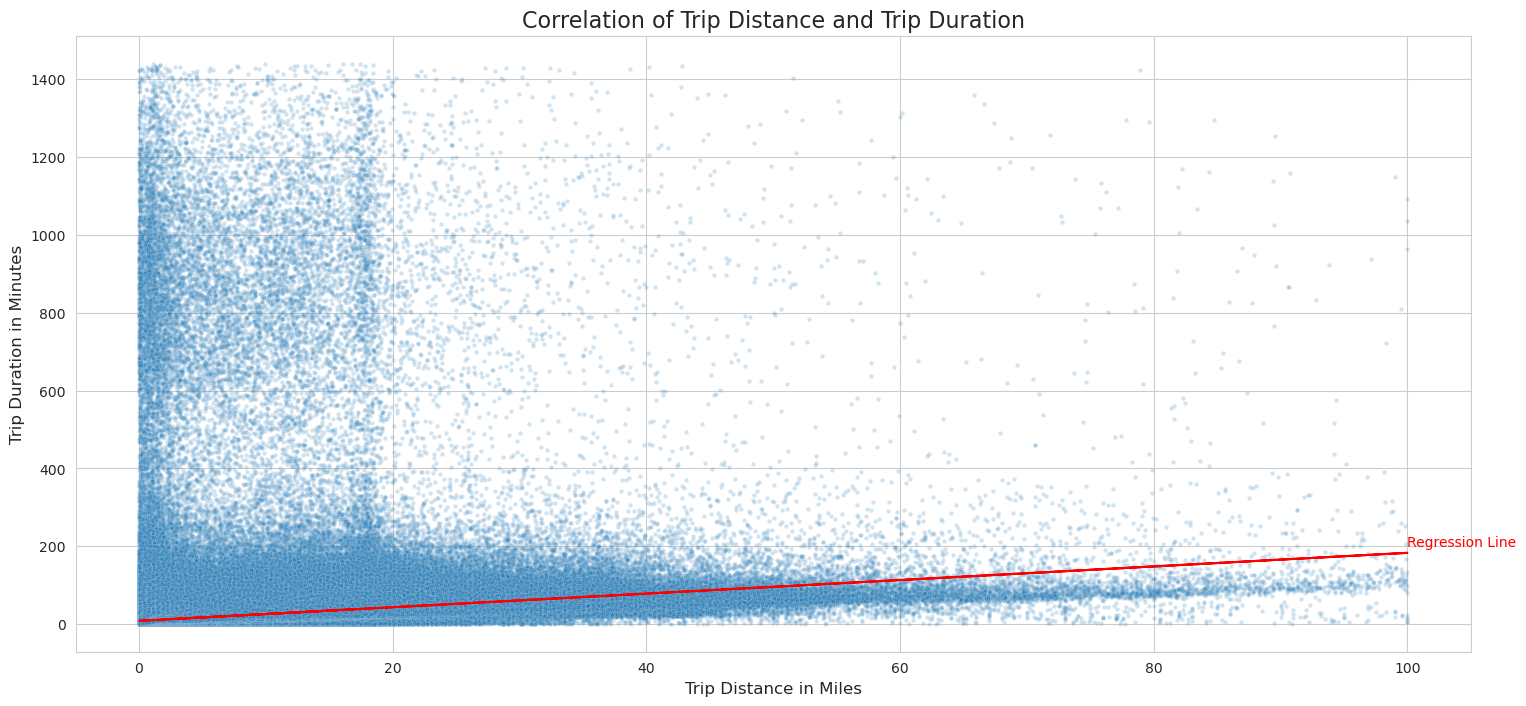

In [102]:
sns.set_style("whitegrid")

plt.figure(figsize=(18, 8))
coefficients = np.polyfit(df_miles_minutes['trip_miles'], df_miles_minutes['trip_minutes'], 1)
linear_fit = np.poly1d(coefficients)

sns.scatterplot(data=df_miles_minutes, x='trip_miles', y='trip_minutes', s=10, alpha=0.2)
plt.plot(df_miles_minutes['trip_miles'], linear_fit(df_miles_minutes['trip_miles']), color='red')

plt.text(100, 200, "Regression Line", color="red")

plt.title('Correlation of Trip Distance and Trip Duration', fontsize=16)
plt.xlabel('Trip Distance in Miles', fontsize=12)
plt.ylabel('Trip Duration in Minutes', fontsize=12)

plt.show()

**Summary:** The scatter plot shows that there is some linear relationship between trip distance and duration, but there are many datapoints that lies further away from the line especially in the case where the distance is shot. A moderate correlation of 0.42 indicated that in general, trip duration increases when the distance increases. However, the correlation is not particularly strong, which suggests that there may be external influence, such as traffic and weather condition or highways, that cause the trip to become shorter or longer than expected.

### 4.6 What is the correlation between trip distance and fare?

In [103]:
taxi_trips_miles_fare = taxi_trips[['trip_miles', 'fare']]

In [104]:
taxi_trips_miles_fare = taxi_trips_miles_fare.na.drop(subset=['trip_miles'])
df_miles_fare = taxi_trips_miles_fare.toPandas()
df_miles_fare = df_miles_fare[(df_miles_fare["trip_miles"] > 0) & (df_miles_fare["trip_miles"] <= 100) & (df_miles_fare["fare"] <= 1000)]

In [105]:
correlation = df_miles_fare['fare'].corr(df_miles_fare['trip_miles'])
print(f"Correlation between fare and trip_miles: {correlation:.2f}")

Correlation between fare and trip_miles: 0.90


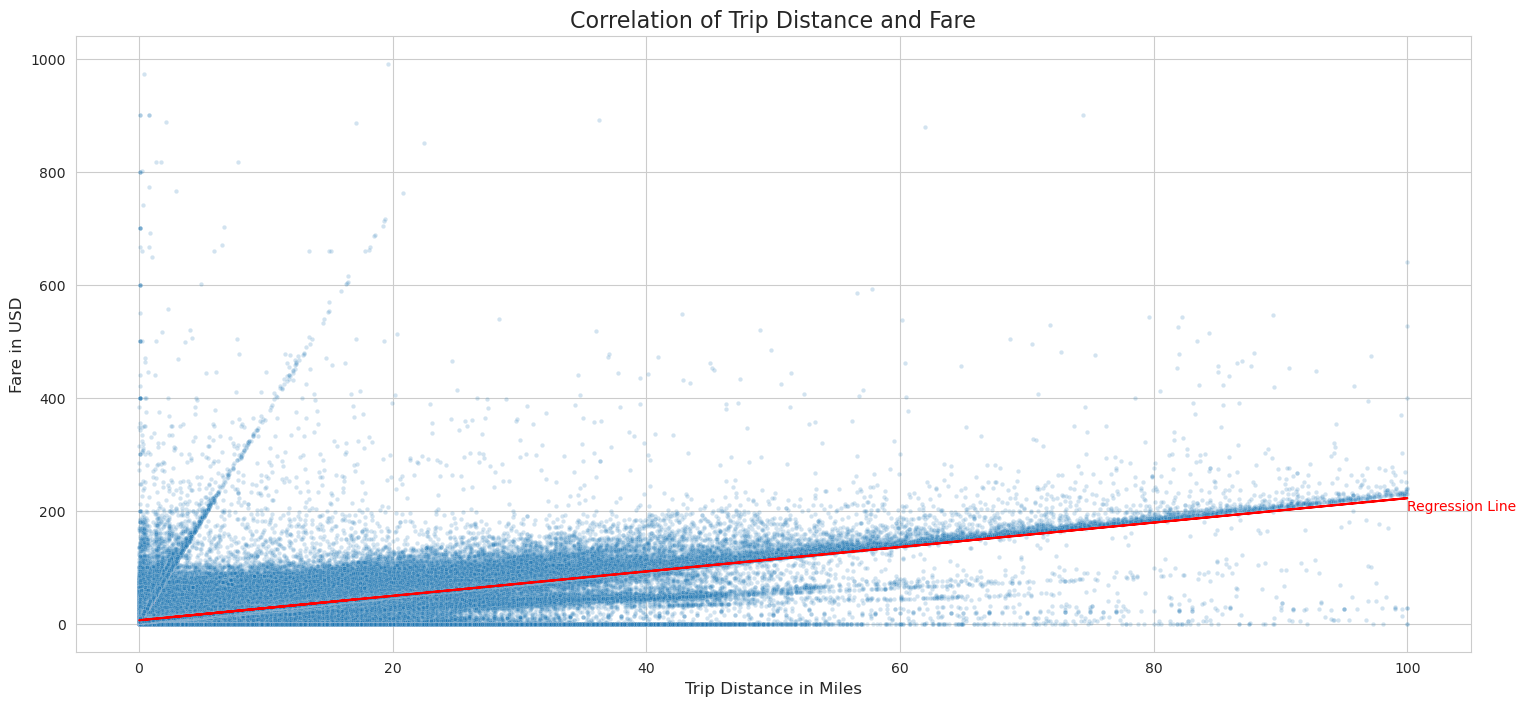

In [106]:
import matplotlib as mpl

sns.set_style("whitegrid")

plt.figure(figsize=(18, 8))
coefficients = np.polyfit(df_miles_fare['trip_miles'], df_miles_fare['fare'], 1)
linear_fit = np.poly1d(coefficients)

sns.scatterplot(data=df_miles_fare, x='trip_miles', y='fare', s=10, alpha=0.2)
plt.plot(df_miles_fare['trip_miles'], linear_fit(df_miles_fare['trip_miles']), color='red')

plt.text(100, 200, "Regression Line", color="red")

plt.title('Correlation of Trip Distance and Fare', fontsize=16)
plt.xlabel('Trip Distance in Miles', fontsize=12)
plt.ylabel('Fare in USD', fontsize=12)

plt.show()

**Summary:** The scatter plot and the correlation score of 0.90 indicates that there is a very strong linear relationship between trip distance and duration. Trip fare increases as the distance increases. Trips where the fare is higher than typical of the distance indicates that traffic conditions may cause the charges to go up while distance remains the same.

### Summarized Exploratory Analysis
The analysis of the Chicago taxi trip data reveals several important trends. First, the distribution of trip durations is right-skewed, indicating that although the majority of trips are short, a few long trips (outliers) significantly pull the average up. Similarly, the distribution of trip distances is also right-skewed, suggesting that most trips are short, with a smaller number of much longer trips increasing the average. There is a local minimum between 16 and 20 miles, which may reflect inter-city trips where the pick-up or drop-off locations are outside Chicago, contributing to the longer trip distances. The fare distribution follows a right-skewed pattern as well, indicating that while most trips cost around 10.50 USD, a small number of trips with higher fares (likely due to longer distances) are driving the average up.

In terms of broader industry trends, the number of taxi cars and companies declined steadily from 2019 to 2021, following a similar pattern to the drop in taxi trip counts. This decline was primarily driven by COVID-19 restrictions in 2020, which caused a sharp drop in taxi trip demand. However, trip demand began to recover in 2021, although it did not return to pre-COVID levels. The continued decrease in the number of taxi cars and companies after the restrictions were lifted suggests that many drivers switched careers or that taxi companies shut down due to financial losses and increasing competition from rideshare apps.

The analysis also shows a moderate correlation (0.42) between trip duration and distance, indicating that longer trips generally take more time. However, the correlation is not very strong, suggesting that other factors, such as traffic or weather conditions, may be influencing trip duration. Additionally, a very strong linear relationship (0.90 correlation) exists between trip distance and fare, with longer trips typically resulting in higher fares. Outliers where the fare is higher than expected for the distance are likely due to external factors, such as traffic conditions, that increase the fare while the trip distance remains constant.

Overall, the analysis highlights the interplay between trip characteristics—such as duration, distance, and fare—and external factors like COVID-19, traffic, and competition from rideshare services, providing a comprehensive view of the dynamics within the Chicago taxi industry.

## 5. Taxi Hotspot Analysis <a class="anchor" id="5"></a>
---

In [107]:
import geopandas as gpd
from shapely.wkt import loads
from matplotlib.colors import Normalize
import matplotlib.colorbar as mcolorbar
import matplotlib.cm as cm
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Patch

Chicago city is divided into 77 community areaa, which is given by the community area dataset.

Remove AREA_NUMBER -1 because it doesn't contain geographical data and will cause error when plotting a map.

In [108]:
community_areas_pd = community_areas.where(~col("the_geom").isNull()).toPandas()

In [109]:
community_areas_pd["geometry"] = community_areas_pd["the_geom"].apply(loads)
gdf = gpd.GeoDataFrame(community_areas_pd, geometry="geometry")
gdf.set_crs(epsg=4326, inplace=True)

,the_geom,AREA_NUMBER,COMMUNITY,SHAPE_AREA,SHAPE_LEN,geometry
0,MULTIPOLYGON (((-87.60914087617894 41.84469250...,35,DOUGLAS,46004621.1581,31027.0545098,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ..."
1,MULTIPOLYGON (((-87.59215283879394 41.81692934...,36,OAKLAND,16913961.0408,19565.5061533,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ..."
2,MULTIPOLYGON (((-87.62879823733725 41.80189303...,37,FULLER PARK,19916704.8692,25339.0897503,"MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ..."
3,MULTIPOLYGON (((-87.6067081256125 41.816813770...,38,GRAND BOULEVARD,48492503.1554,28196.8371573,"MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ..."
4,MULTIPOLYGON (((-87.59215283879394 41.81692934...,39,KENWOOD,29071741.9283,23325.1679062,"MULTIPOLYGON (((-87.59215 41.81693, -87.59215 ..."
...,...,...,...,...,...,...
72,MULTIPOLYGON (((-87.69645961375822 41.70714491...,74,MOUNT GREENWOOD,75584290.0209,48665.1305392,"MULTIPOLYGON (((-87.69646 41.70714, -87.69644 ..."
73,MULTIPOLYGON (((-87.64215204651398 41.68508211...,75,MORGAN PARK,91877340.6988,46396.419362,"MULTIPOLYGON (((-87.64215 41.68508, -87.64249 ..."
74,MULTIPOLYGON (((-87.83658087874365 41.98639611...,76,OHARE,371835607.687,173625.98466,"MULTIPOLYGON (((-87.83658 41.98640, -87.83658 ..."
75,MULTIPOLYGON (((-87.65455590025104 41.99816614...,77,EDGEWATER,48449990.8397,31004.8309456,"MULTIPOLYGON (((-87.65456 41.99817, -87.65456 ..."


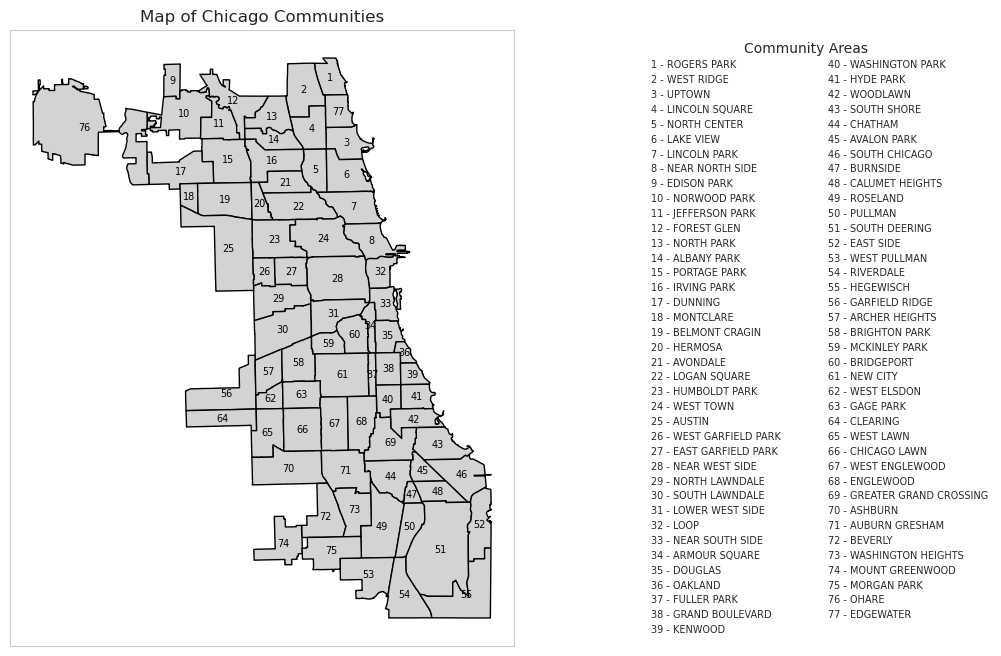

In [110]:
gdf = gdf.sort_values(by="AREA_NUMBER")

fig, ax = plt.subplots(figsize=(10,8))
gdf.plot(
    color="lightgray",
    edgecolor="black",
    ax=ax
)

for _, row in gdf.iterrows():
    centroid = row.geometry.centroid
    ax.text(
        centroid.x, centroid.y,
        str(row["AREA_NUMBER"]),
        fontsize=7,
        color="black",
        ha="center",
        va="center",
    )

# Prepare legend handles
legend_handles = [
    Patch(color="none", label=f"{row['AREA_NUMBER']} - {row['COMMUNITY']}") 
    for _, row in gdf.iterrows()
]

# Add the legend with multiple columns
ax.legend(
    handles=legend_handles,
    title="Community Areas",
    loc="center left",
    bbox_to_anchor=(1.2, 0.5),
    ncol=2,
    fontsize=7,
    title_fontsize=10,
    frameon=False
)

# Add title and axis labels
ax.set_title("Map of Chicago Communities", fontsize=12)
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)

plt.show()

### 5.1 Which locations see a large demand in taxi pickups and dropoffs?

In [111]:
taxi_pickup_community_area = taxi_trips.groupBy("pickup_community_area").count().withColumnRenamed("count", "ride_frequency").toPandas()
taxi_pickup_community_area_gdf = gdf.merge(taxi_pickup_community_area, left_on="AREA_NUMBER", right_on="pickup_community_area", how="inner")

In [112]:
taxi_pickup_community_area_gdf.sort_values(by="ride_frequency", ascending=False).head(5)

,the_geom,AREA_NUMBER,COMMUNITY,SHAPE_AREA,SHAPE_LEN,geometry,pickup_community_area,ride_frequency
7,MULTIPOLYGON (((-87.62446476694345 41.91156699...,8,NEAR NORTH SIDE,76675895.9728,57293.1649516,"MULTIPOLYGON (((-87.62446 41.91157, -87.62459 ...",8,5883327
31,MULTIPOLYGON (((-87.6094858028664 41.889399110...,32,LOOP,46335565.4586,39428.6729962,"MULTIPOLYGON (((-87.60949 41.88940, -87.60949 ...",32,4529176
75,MULTIPOLYGON (((-87.83658087874365 41.98639611...,76,OHARE,371835607.687,173625.98466,"MULTIPOLYGON (((-87.83658 41.98640, -87.83658 ...",76,2784594
27,MULTIPOLYGON (((-87.6375883858287 41.886234136...,28,NEAR WEST SIDE,158492466.554,53003.5929406,"MULTIPOLYGON (((-87.63759 41.88623, -87.63765 ...",28,2135936
5,MULTIPOLYGON (((-87.64102430213292 41.95480280...,6,LAKE VIEW,87214799.2728,51973.0968677,"MULTIPOLYGON (((-87.64102 41.95480, -87.64101 ...",6,809968


In [113]:
taxi_dropoff_community_area = taxi_trips.groupBy("dropoff_community_area").count().withColumnRenamed("count", "ride_frequency").toPandas()
taxi_dropoff_community_area_gdf = gdf.merge(taxi_dropoff_community_area, left_on="AREA_NUMBER", right_on="dropoff_community_area", how="inner")

In [114]:
taxi_dropoff_community_area_gdf.sort_values(by="ride_frequency", ascending=False).head(5)

,the_geom,AREA_NUMBER,COMMUNITY,SHAPE_AREA,SHAPE_LEN,geometry,dropoff_community_area,ride_frequency
7,MULTIPOLYGON (((-87.62446476694345 41.91156699...,8,NEAR NORTH SIDE,76675895.9728,57293.1649516,"MULTIPOLYGON (((-87.62446 41.91157, -87.62459 ...",8,5778181
31,MULTIPOLYGON (((-87.6094858028664 41.889399110...,32,LOOP,46335565.4586,39428.6729962,"MULTIPOLYGON (((-87.60949 41.88940, -87.60949 ...",32,3951414
27,MULTIPOLYGON (((-87.6375883858287 41.886234136...,28,NEAR WEST SIDE,158492466.554,53003.5929406,"MULTIPOLYGON (((-87.63759 41.88623, -87.63765 ...",28,2201751
5,MULTIPOLYGON (((-87.64102430213292 41.95480280...,6,LAKE VIEW,87214799.2728,51973.0968677,"MULTIPOLYGON (((-87.64102 41.95480, -87.64101 ...",6,1028970
6,MULTIPOLYGON (((-87.63181810269614 41.93258180...,7,LINCOLN PARK,88316400.4728,49478.4277714,"MULTIPOLYGON (((-87.63182 41.93258, -87.63182 ...",7,928041


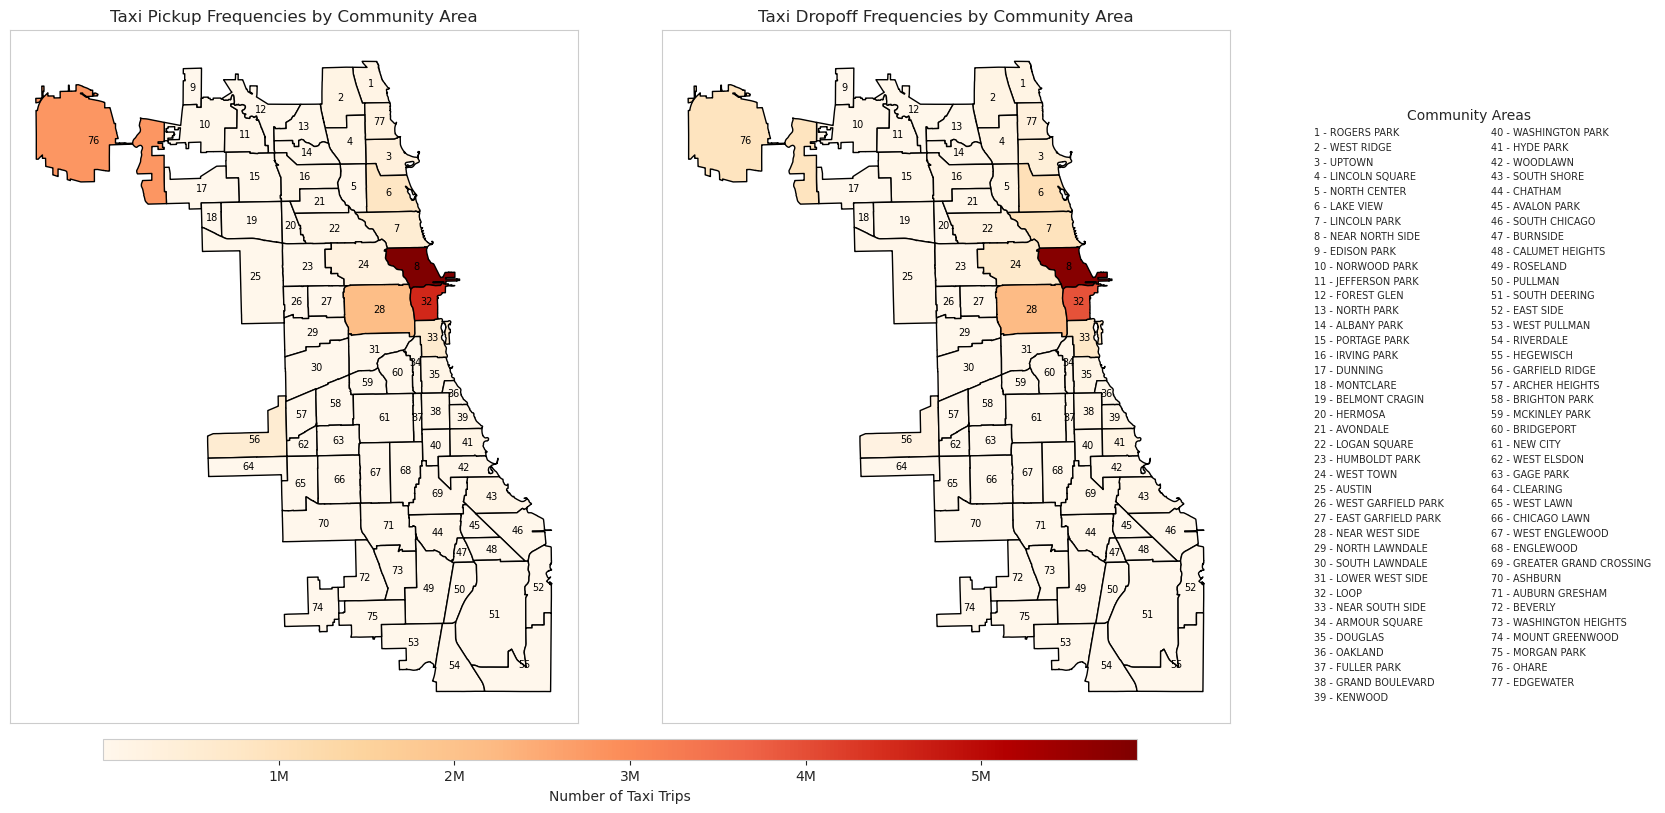

In [115]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter

# Normalize ride frequencies for shared color scale
vmin = min(
    taxi_pickup_community_area_gdf["ride_frequency"].min(),
    taxi_dropoff_community_area_gdf["ride_frequency"].min()
)
vmax = max(
    taxi_pickup_community_area_gdf["ride_frequency"].max(),
    taxi_dropoff_community_area_gdf["ride_frequency"].max()
)
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.OrRd

# Add a color column to both GeoDataFrames
taxi_pickup_community_area_gdf["color"] = taxi_pickup_community_area_gdf["ride_frequency"].apply(lambda x: cmap(norm(x)))
taxi_dropoff_community_area_gdf["color"] = taxi_dropoff_community_area_gdf["ride_frequency"].apply(lambda x: cmap(norm(x)))

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 8), constrained_layout=True)

# Plot Pickup Data
taxi_pickup_community_area_gdf.plot(
    color=taxi_pickup_community_area_gdf["color"],
    edgecolor="black",
    ax=ax1
)
ax1.set_title("Taxi Pickup Frequencies by Community Area", fontsize=12)
ax1.set_xticks([])
ax1.set_yticks([])

for _, row in taxi_pickup_community_area_gdf.iterrows():
    centroid = row.geometry.centroid
    ax1.text(
        centroid.x, centroid.y,
        str(row["AREA_NUMBER"]),
        fontsize=7,
        color="black",
        ha="center",
        va="center"
    )

# Plot Dropoff Data
taxi_dropoff_community_area_gdf.plot(
    color=taxi_dropoff_community_area_gdf["color"],
    edgecolor="black",
    ax=ax2
)
ax2.set_title("Taxi Dropoff Frequencies by Community Area", fontsize=12)
ax2.set_xticks([])
ax2.set_yticks([])

for _, row in taxi_dropoff_community_area_gdf.iterrows():
    centroid = row.geometry.centroid
    ax2.text(
        centroid.x, centroid.y,
        str(row["AREA_NUMBER"]),
        fontsize=7,
        color="black",
        ha="center",
        va="center"
    )

# Add a shared horizontal colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=[ax1, ax2], orientation="horizontal", pad=0.02, aspect=50, shrink=0.8)
cbar.set_label("Number of Taxi Trips", fontsize=10)
cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x / 1_000_000:.0f}M"))

# Shared legend for community areas
legend_handles = [
    Patch(color="none", label=f"{row['AREA_NUMBER']} - {row['COMMUNITY']}") 
    for _, row in gdf.iterrows()
]
fig.legend(
    handles=legend_handles,
    title="Community Areas",
    loc="center right",
    bbox_to_anchor=(1.3, 0.5),
    ncol=2,
    fontsize=7,
    title_fontsize=10,
    frameon=False
)

plt.show()

**Summary:** We can see from the heatmap above that Near North Side and Loop have more than 4 million pickups and 4 million drop offs from 2018 to 2023. This makes sense because both areas are the downtown area where business districts and popular tourist attractions are located. Near West side also see significant pickup and dropoff due to it's proximity to downtown and sport stadiums such as the Chicago Bulls and the Chicago Blackhawks. O'Hare sees around 3 million pickups over the 6 years, which makes it the third pickup hotspot in Chicago due to it being where Chicago O'Hare International Airport is located.

### 5.2 How much are traffic in the hotspot areas affected by work commute?

In [116]:
from pyspark.sql.functions import date_format, hour

In [117]:
downtown_pickup_trips = taxi_trips.where((col("pickup_community_area") == 8) | (col("pickup_community_area") == 32))
downtown_pickup_trips = downtown_pickup_trips.withColumn("day_of_week", date_format(col("trip_start_timestamp"), "EEEE")) \
                        .withColumn("hour_of_day", hour(col("trip_start_timestamp")) \
                        .cast(IntegerType()))
workday_downtown_pickup_trips = downtown_pickup_trips.where(col("day_of_week").isin("Monday", "Tuesday", "Wednesday", "Thursday", "Friday"))
workday_downtown_pickup_trips = workday_downtown_pickup_trips.groupBy("hour_of_day").agg(count("*").alias("total_ride_pickups")).orderBy("hour_of_day")

In [118]:
workday_downtown_pickup_trips.show(24)

+-----------+------------------+
|hour_of_day|total_ride_pickups|
+-----------+------------------+
|          0|             91110|
|          1|             60116|
|          2|             38419|
|          3|             30736|
|          4|             30117|
|          5|             48462|
|          6|            104078|
|          7|            233833|
|          8|            374386|
|          9|            400802|
|         10|            399385|
|         11|            473759|
|         12|            517419|
|         13|            523684|
|         14|            530915|
|         15|            566805|
|         16|            645115|
|         17|            701937|
|         18|            672743|
|         19|            545671|
|         20|            394637|
|         21|            316639|
|         22|            266107|
|         23|            184324|
+-----------+------------------+



In [119]:
downtown_dropoff_trips = taxi_trips.where((col("dropoff_community_area") == 8) | (col("dropoff_community_area") == 32))
downtown_dropoff_trips = downtown_dropoff_trips.withColumn("day_of_week", date_format(col("trip_end_timestamp"), "EEEE")) \
                                                .withColumn("hour_of_day", hour(col("trip_end_timestamp")) \
                                                .cast(IntegerType()))
workday_downtown_dropoff_trips = downtown_dropoff_trips.where(col("day_of_week").isin("Monday", "Tuesday", "Wednesday", "Thursday", "Friday"))
workday_downtown_dropoff_trips = workday_downtown_dropoff_trips.groupBy("hour_of_day").agg(count("*").alias("total_ride_dropoffs")).orderBy("hour_of_day")

In [120]:
workday_downtown_dropoff_trips.show(24)

+-----------+-------------------+
|hour_of_day|total_ride_dropoffs|
+-----------+-------------------+
|          0|              95116|
|          1|              61649|
|          2|              34819|
|          3|              21390|
|          4|              15496|
|          5|              24326|
|          6|              78386|
|          7|             237819|
|          8|             444971|
|          9|             510138|
|         10|             466135|
|         11|             471406|
|         12|             509622|
|         13|             512319|
|         14|             501144|
|         15|             497847|
|         16|             526938|
|         17|             563847|
|         18|             563722|
|         19|             475979|
|         20|             362681|
|         21|             297050|
|         22|             249484|
|         23|             174966|
+-----------+-------------------+



In [121]:
workday_downtown_pickup_trips_pd = workday_downtown_pickup_trips.toPandas()
workday_downtown_dropoff_trips_pd = workday_downtown_dropoff_trips.toPandas()

workday_downtown_trips = pd.merge(
    workday_downtown_pickup_trips_pd,
    workday_downtown_dropoff_trips_pd,
    on="hour_of_day",
)

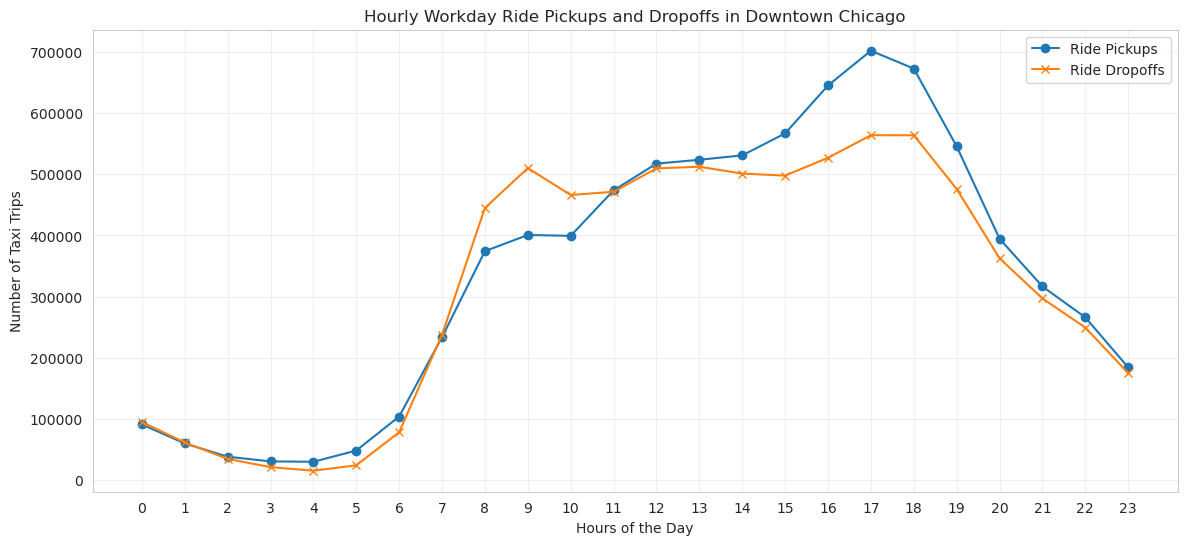

In [122]:
plt.figure(figsize=(14, 6))
plt.plot(workday_downtown_trips['hour_of_day'], workday_downtown_trips['total_ride_pickups'], label='Ride Pickups', marker='o')
plt.plot(workday_downtown_trips['hour_of_day'], workday_downtown_trips['total_ride_dropoffs'], label='Ride Dropoffs', marker='x')

plt.title('Hourly Workday Ride Pickups and Dropoffs in Downtown Chicago')
plt.xlabel('Hours of the Day')
plt.ylabel('Number of Taxi Trips')
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

**Summary**: Taxi ride demands in Downtown area is significantly affected by work hours. The number of both pickups and dropoffs increases sharply at 6AM and continue to increase at a rapid rate until 8AM, which is the time when commuters leave home for work assuming the regular work hours start at 9AM. The number of taxi pickups and dropoffs remain high during work hours due to visits to different businesses in Downtown. At 4-5PM, taxi pickups peak because it is the time when people leave work and continue decreasing as the time goes on.

## 6. Time Analysis <a class="anchor" id="6"></a>
---

In [123]:
from pyspark.sql.functions import date_format, hour, month, year, dayofmonth

### 6.1 What are the difference in taxi demand based on month of the year, day of the week, and time of the day?

In [124]:
time_trips = (
    taxi_trips \
    .withColumn("year", year(col("trip_start_timestamp"))) \
    .withColumn("month", month(col("trip_start_timestamp"))) \
    .withColumn("day_of_month", dayofmonth(col("trip_start_timestamp"))) \
    .withColumn("day_of_week", date_format(col("trip_start_timestamp"), "EEEE")) \
    .withColumn("hour_of_day", hour(col("trip_start_timestamp")).cast(IntegerType()))
)

month_year_trips_pd = time_trips.groupBy("year", "month") \
    .agg(count("*").alias("total_rides")) \
    .orderBy("year", "month").toPandas()

In [125]:
month_year_trips_pd

,year,month,total_rides
0,2018,1,440548
1,2018,2,401861
2,2018,3,501371
3,2018,4,463480
4,2018,5,453901
...,...,...,...
66,2023,8,69793
67,2023,9,518791
68,2023,10,1299
69,2023,11,5160


In [126]:
month_day_trips_pd = time_trips.groupBy("month", "day_of_month") \
    .agg(count("*").alias("total_rides")) \
    .orderBy("month", "day_of_month").toPandas()

In [127]:
month_day_trips_pd

,month,day_of_month,total_rides
0,1,1,54007
1,1,2,61400
2,1,3,70897
3,1,4,64429
4,1,5,60399
...,...,...,...
361,12,27,56869
362,12,28,55392
363,12,29,51056
364,12,30,58246


In [128]:
day_week_month_trips = time_trips.groupBy("month", "day_of_week").agg(count("*").alias("total_rides")).toPandas()

In [129]:
day_week_month_trips

,month,day_of_week,total_rides
0,4,Wednesday,239786
1,8,Thursday,229916
2,3,Monday,273188
3,3,Sunday,206414
4,11,Sunday,170820
...,...,...,...
79,6,Wednesday,227236
80,6,Thursday,227032
81,6,Tuesday,212180
82,6,Friday,245134


In [130]:
hour_day_trips = (
    time_trips.groupBy("hour_of_day", "day_of_week")
    .agg(count("*").alias("total_rides"))
    .toPandas()
)

In [131]:
hour_day_trips

,hour_of_day,day_of_week,total_rides
0,4,Wednesday,17299
1,8,Thursday,197752
2,9,Saturday,98168
3,7,Thursday,129746
4,3,Monday,19767
...,...,...,...
163,9,Tuesday,215745
164,23,Saturday,135654
165,23,Tuesday,75833
166,23,Thursday,105910


In [132]:
day_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
hour_of_day = np.arange(24)
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
year_labels = np.arange(2018, 2024)

In [133]:
all_years = month_year_trips_pd["year"].unique()
all_months = range(1, 13)

# Create a full index with all combinations of years and months
full_index = pd.MultiIndex.from_product([all_years, all_months], names=["year", "month"])

# Reindex the DataFrame to include all combinations, filling missing values with 0
month_year_trips_full = month_year_trips_pd.set_index(["year", "month"]) \
    .reindex(full_index, fill_value=0) \
    .reset_index()

heatmap_month_year_data = month_year_trips_full.pivot(index="year", columns="month", values="total_rides")
heatmap_day_week_month_data = day_week_month_trips.pivot(index="month", columns="day_of_week", values="total_rides").reindex(columns=day_order)
heatmap_hour_day_data = hour_day_trips.pivot(index="day_of_week", columns="hour_of_day", values="total_rides").reindex(index=day_order)

In [388]:
def format_colorbar(cbar_axis):
    cbar_axis.yaxis.set_major_formatter(
        FuncFormatter(
            lambda x, _: f"{int(x / 1000000)}M" if x >= 1000000 else 
            f"{int(x / 1000)}K" if x >= 1000 else 
            f"{int(x)}"
        )
    )

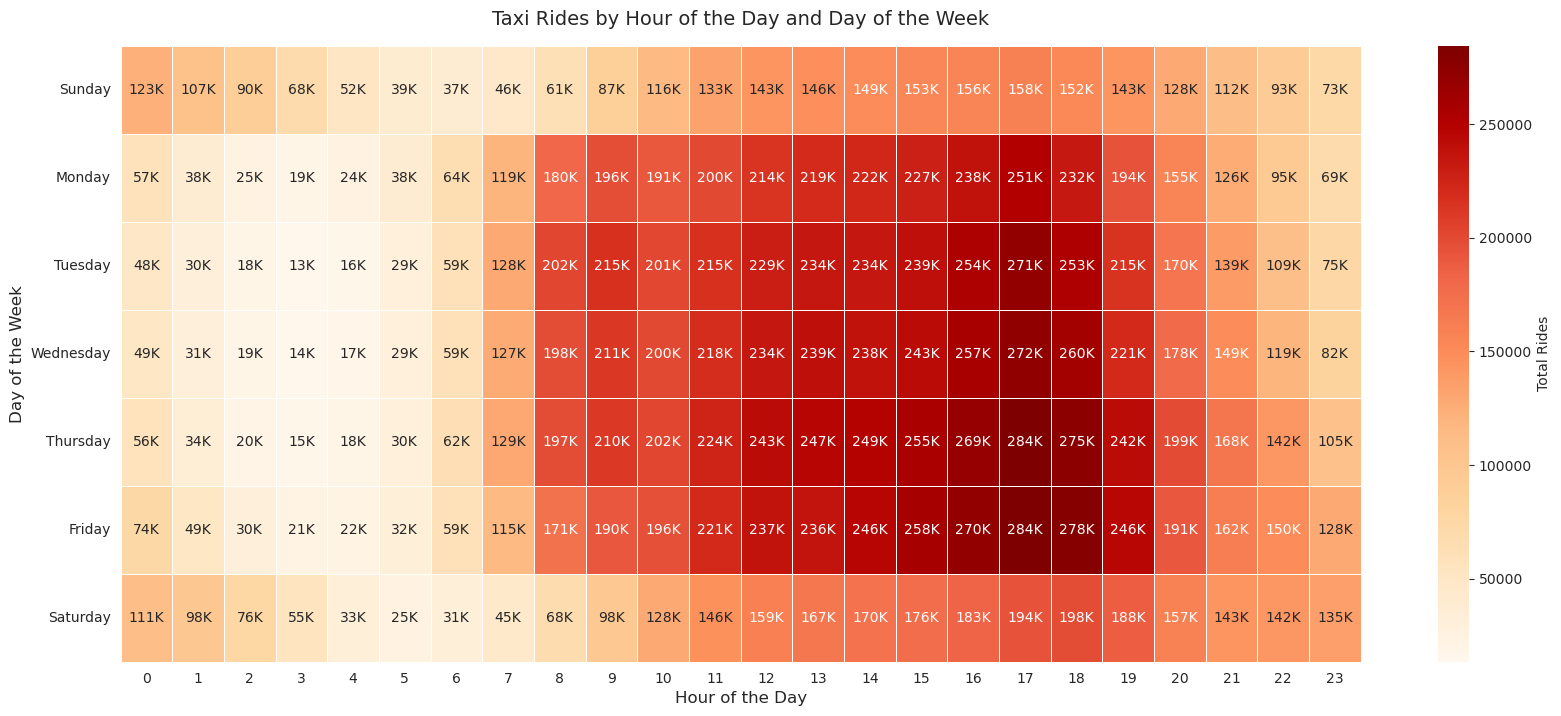

In [391]:
plt.figure(figsize=(20, 8))

sns.heatmap(
    heatmap_hour_day_data,
    annot=True,
    fmt=".0f",
    cmap=plt.cm.OrRd,
    linewidths=0.5,
    cbar_kws={"label": "Total Rides"}
)

plt.title("Taxi Rides by Hour of the Day and Day of the Week", fontsize=14, pad=15)
plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Day of the Week", fontsize=12)

plt.xticks(rotation=0)
plt.yticks(rotation=0)

for text in plt.gca().texts:
    value = int(text.get_text())
    if value >= 1_000_000:
        text.set_text(f"{value // 1_000_000}M")
    elif value >= 1_000:
        text.set_text(f"{value // 1_000}K")
    else:
        text.set_text(f"{value}")

plt.show()

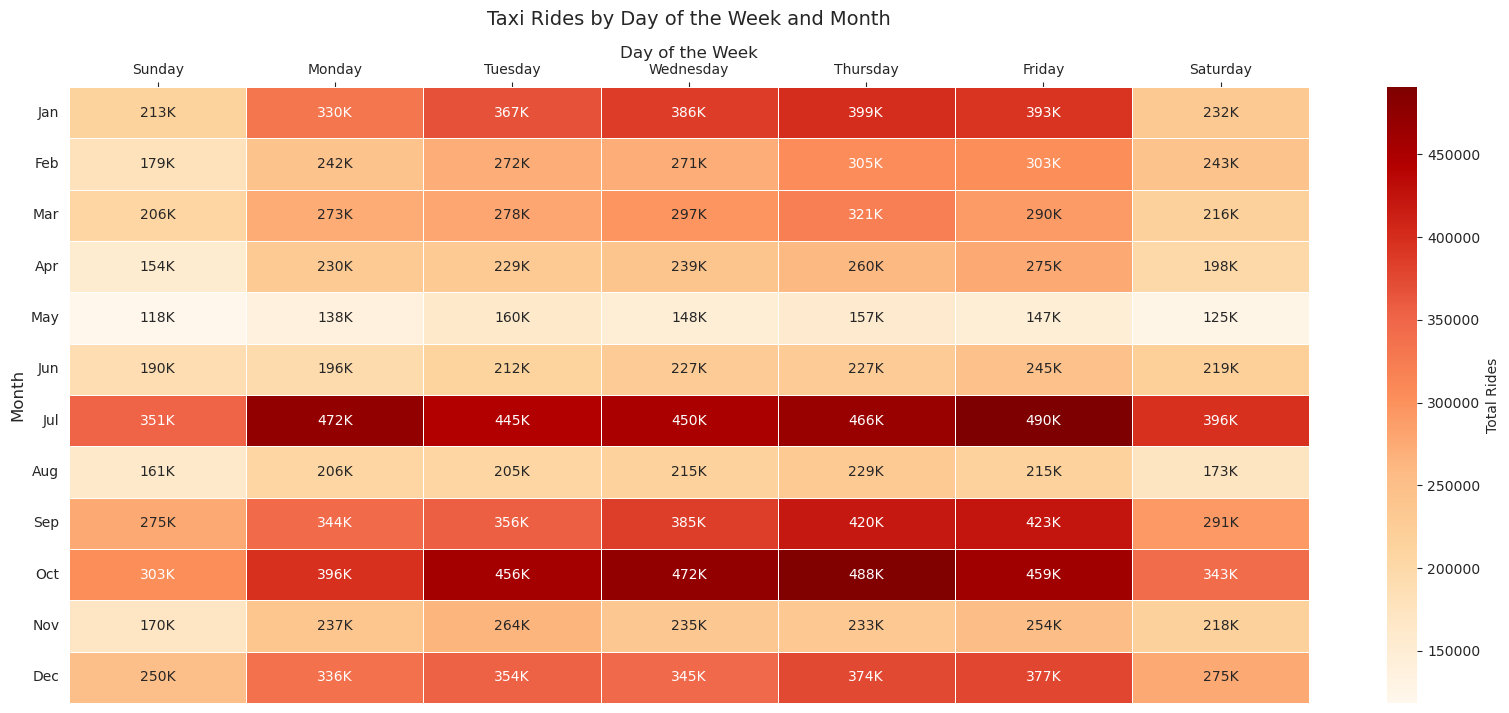

In [392]:
plt.figure(figsize=(20, 8))

sns.heatmap(
    heatmap_day_week_month_data,
    annot=True,
    fmt=".0f",
    cmap=plt.cm.OrRd,
    linewidths=0.5,
    cbar_kws={"label": "Total Rides"}
)

plt.title("Taxi Rides by Day of the Week and Month", fontsize=14, pad=15)
plt.xlabel("Day of the Week", fontsize=12)
plt.ylabel("Month", fontsize=12)

plt.yticks(np.arange(len(heatmap_day_week_month_data.index)) + 0.5, labels=month_labels, rotation=0)

plt.xticks(rotation=0)
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()

for text in plt.gca().texts:
    value = int(text.get_text())
    if value >= 1_000_000:
        text.set_text(f"{value // 1_000_000}M")
    elif value >= 1_000:
        text.set_text(f"{value // 1_000}K")
    else:
        text.set_text(f"{value}")

plt.show()


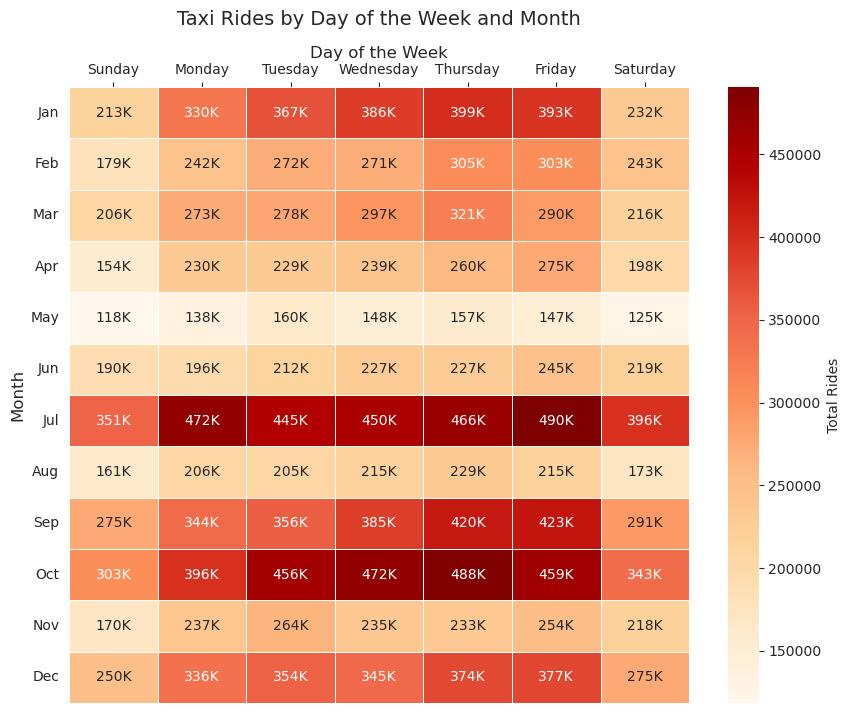

In [393]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 8))

sns.heatmap(
    heatmap_day_week_month_data,
    annot=True,
    fmt=".0f",
    cmap=plt.cm.OrRd,
    linewidths=0.5,
    cbar_kws={"label": "Total Rides"}
)

plt.title("Taxi Rides by Day of the Week and Month", fontsize=14, pad=15)
plt.xlabel("Day of the Week", fontsize=12)
plt.ylabel("Month", fontsize=12)

plt.yticks(np.arange(len(heatmap_day_week_month_data.index)) + 0.5, labels=month_labels, rotation=0)

plt.xticks(rotation=0)
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()

for text in plt.gca().texts:
    value = int(text.get_text())
    if value >= 1_000_000:
        text.set_text(f"{value // 1_000_000}M")
    elif value >= 1_000:
        text.set_text(f"{value // 1_000}K")
    else:
        text.set_text(f"{value}")

plt.show()

**Summary:** The heatmaps above shows the number of taxi ride with different datetime scope. The first plot shows taxi rides by time of the day for each day of the week. Thereis a concentration of taxi rides during the work hours on Monday through Friday from 7AM to 7PM, which Friday seeing more rides at night more than other work days which could be attributed to the face that it is the end of a work week. The second plot shows taxi rides by day of the week for each month. Comparing the days in each month, we can see that most rides are concentrated on the work days for every month. July and October seems to see a big surge in taxi rides on weekends. After some research, we found that Chicago hosted several big events in July and October in 2019, including Taste of Chicago, Windy City Smokeout, Pitchfork Music Festival, Bank of America Chicago Marathon, and Open House Chicago, al of which span the weekends. While these events happen every year, some never got back to the same number of participants as before COVID-19, as can be seen from the third plot showing the number of taxi rides by onths for each year from 2018 to 2023.

Note: There are unexplanable drops in the number of taxi rides in multiple months of different years. Notably, in May 2019 where there are only 6 rides recorded and in May 2023 where there is 0 taxi ride recorded. We thinks that it is unlikely that there was 0 rides happening in the entire month. It is more likely that there are data-related issues in months where there are fewer than some thousands taxi rides.

## 7. Congestion Analysis <a class="anchor" id="7"></a>
---

### 7.1 What time of the day is traffic bad?

In [336]:
from pyspark.sql.functions import to_timestamp, hour
taxi_trip_time_of_day = taxi_trips.withColumn("hour_of_day", hour("trip_start_timestamp")).withColumn("trip_speed", col("trip_miles") / (col("trip_minutes") / 60.0))

In [337]:
taxi_trip_time_of_day.select("trip_miles", "trip_minutes", "trip_speed").limit(5).toPandas()

,trip_miles,trip_minutes,trip_speed
0,17.04,26,39.32
1,16.68,35,28.59
2,7.49,20,22.47
3,0.60,5,7.20
4,15.41,32,28.89


In [339]:
from pyspark.sql.functions import avg

congestion_analysis = taxi_trip_time_of_day.groupBy("hour_of_day").agg(
    avg("trip_speed").alias("avg_trip_speed")
)

congestion_analysis = congestion_analysis.orderBy("avg_trip_speed", ascending=False)
congestion_analysis.toPandas()

,hour_of_day,avg_trip_speed
0,5,26.40
1,4,23.23
2,6,21.80
3,0,19.13
4,23,18.50
5,21,18.36
6,3,18.22
7,1,18.06
8,22,17.78
9,20,17.21


In [261]:
extract.createOrReplaceTempView("extract_table")
avg_speed_all_hours = spark.sql("SELECT AVG(trip_speed) AS avg_speed FROM extract_table").collect()[0]["avg_speed"]

In [262]:
avg_speed_all_hours

15.189065445736938

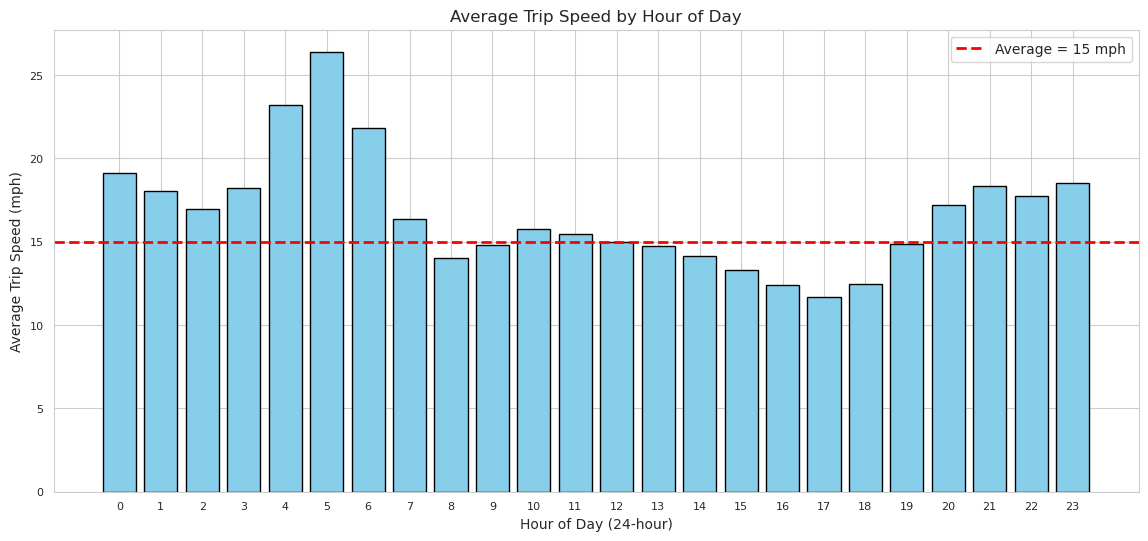

In [340]:
import pandas as pd
import matplotlib.pyplot as plt

congestion_df = congestion_analysis.toPandas()

plt.figure(figsize=(14, 6))
plt.bar(congestion_df['hour_of_day'], congestion_df['avg_trip_speed'], color='skyblue', edgecolor='black')
plt.axhline(y=int(avg_speed_all_hours), color='red', linestyle='--', linewidth=2, label=f'Average = {int(avg_speed_all_hours)} mph')

plt.xlabel('Hour of Day (24-hour)', fontsize=10)
plt.ylabel('Average Trip Speed (mph)', fontsize=10)
plt.title('Average Trip Speed by Hour of Day', fontsize=12)
plt.xticks(range(24), fontsize=8)
plt.yticks(fontsize=8)

plt.legend()
plt.show()

**Summary:** The bar chart displays the average trip speed (in miles per hour) for each hour of the day, using a 24-hour format. The analysis reveals that the morning and afternoon rush hours—8 to 9AM and 1 to 7PM—have the lowest average trip speed, indicating the most severe traffic congestion during these times. In contrast, the early morning and late night hours (0–7AM and 8-11PM) show significantly higher travel speed, reflecting lighter traffic conditions. This is in line with our intuition and observations that traffic is especially bad during the time when commuters leave for work and get off work.

### 7.2 What location have bad traffic?

In [322]:
from pyspark.sql.functions import col

# Add speed calculation
speed = taxi_trips.withColumn("trip_speed", col("trip_miles") / (col("trip_minutes") / 60.0))
speed

DataFrame[trip_id: string, taxi_id: string, trip_start_timestamp: timestamp, trip_end_timestamp: timestamp, trip_miles: double, pickup_community_area: int, dropoff_community_area: int, fare: double, tips: double, tolls: double, extras: double, trip_total: double, payment_type: string, company: string, trip_minutes: int, log_trip_minutes: double, trip_speed: double]

In [323]:
dropoff_congestion_analysis = speed.groupBy("dropoff_community_area").agg(
    avg("trip_speed").alias("avg_trip_speed_by_dropoff_comm")
)

In [324]:
dropoff_avg_speed = dropoff_congestion_analysis.join(
    community_areas,
    dropoff_congestion_analysis["dropoff_community_area"] == community_areas["AREA_NUMBER"],
    how="inner"
).select(
    dropoff_congestion_analysis["*"],
    community_areas["COMMUNITY"],
    community_areas["AREA_NUMBER"]
)

dropoff_avg_speed_pd = dropoff_avg_speed.toPandas()

In [325]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


droff_gdf = gdf.merge(dropoff_avg_speed_pd[['AREA_NUMBER', 'avg_trip_speed_by_dropoff_comm']], on='AREA_NUMBER', how='left')

In [326]:
droff_gdf.sort_values(by="avg_trip_speed_by_dropoff_comm", ascending=False).head(5)

,the_geom,AREA_NUMBER,COMMUNITY,SHAPE_AREA,SHAPE_LEN,geometry,avg_trip_speed_by_dropoff_comm
53,MULTIPOLYGON (((-87.60157012805959 41.68620935...,54,RIVERDALE,98389497.4143,46455.4408571,"MULTIPOLYGON (((-87.60157 41.68621, -87.60158 ...",30.72
74,MULTIPOLYGON (((-87.64215204651398 41.68508211...,75,MORGAN PARK,91877340.6988,46396.419362,"MULTIPOLYGON (((-87.64215 41.68508, -87.64249 ...",27.30
54,MULTIPOLYGON (((-87.52462014976344 41.69180077...,55,HEGEWISCH,145965741.437,73692.3821322,"MULTIPOLYGON (((-87.52462 41.69180, -87.52465 ...",27.16
36,MULTIPOLYGON (((-87.62879823733725 41.80189303...,37,FULLER PARK,19916704.8692,25339.0897503,"MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ...",27.00
75,MULTIPOLYGON (((-87.83658087874365 41.98639611...,76,OHARE,371835607.687,173625.98466,"MULTIPOLYGON (((-87.83658 41.98640, -87.83658 ...",25.66


In [313]:
pickup_congestion_analysis = speed.groupBy("pickup_community_area").agg(
    avg("trip_speed").alias("avg_trip_speed_by_pickup_comm")
)

In [314]:
pickup_avg_speed = pickup_congestion_analysis.join(
    community_areas,
    pickup_congestion_analysis["pickup_community_area"] == community_areas["AREA_NUMBER"],
    how="inner"
).select(
    pickup_congestion_analysis["*"],
    community_areas["COMMUNITY"],
    community_areas["AREA_NUMBER"]
)

pickup_avg_speed_pd = pickup_avg_speed.toPandas()

In [319]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


pickup_gdf = gdf.merge(pickup_avg_speed_pd[['AREA_NUMBER', 'avg_trip_speed_by_pickup_comm']], on='AREA_NUMBER', how='left')

In [320]:
pickup_gdf.sort_values(by="avg_trip_speed_by_pickup_comm", ascending=False).head(5)

,the_geom,AREA_NUMBER,COMMUNITY,SHAPE_AREA,SHAPE_LEN,geometry,avg_trip_speed_by_pickup_comm
54,MULTIPOLYGON (((-87.52462014976344 41.69180077...,55,HEGEWISCH,145965741.437,73692.3821322,"MULTIPOLYGON (((-87.52462 41.69180, -87.52465 ...",31.25
53,MULTIPOLYGON (((-87.60157012805959 41.68620935...,54,RIVERDALE,98389497.4143,46455.4408571,"MULTIPOLYGON (((-87.60157 41.68621, -87.60158 ...",30.81
74,MULTIPOLYGON (((-87.64215204651398 41.68508211...,75,MORGAN PARK,91877340.6988,46396.419362,"MULTIPOLYGON (((-87.64215 41.68508, -87.64249 ...",28.51
52,MULTIPOLYGON (((-87.61828127817006 41.65910686...,53,WEST PULLMAN,99365198.0822,50023.8430008,"MULTIPOLYGON (((-87.61828 41.65911, -87.61829 ...",28.36
36,MULTIPOLYGON (((-87.62879823733725 41.80189303...,37,FULLER PARK,19916704.8692,25339.0897503,"MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ...",27.05


In [327]:
droff_gdf.columns

Index(['the_geom', 'AREA_NUMBER', 'COMMUNITY', 'SHAPE_AREA', 'SHAPE_LEN',
       'geometry', 'avg_trip_speed_by_dropoff_comm'],
      dtype='object')

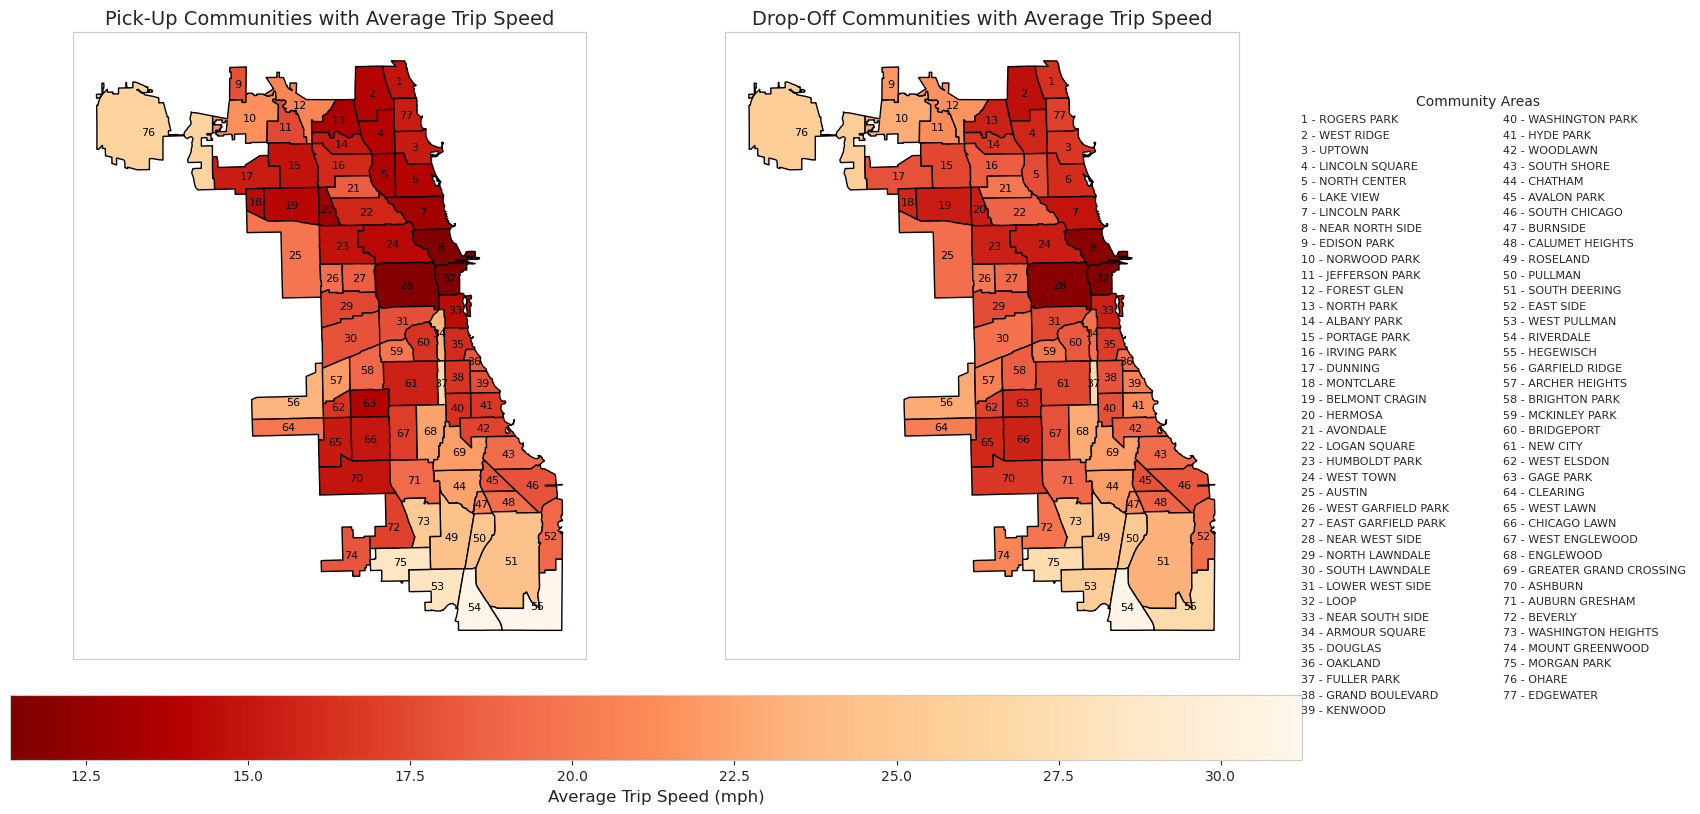

In [334]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.colors as mcolors

# Create a single figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 8), constrained_layout=True)

# Combine min and max values for both datasets to normalize the shared color bar
vmin = min(droff_gdf['avg_trip_speed_by_dropoff_comm'].min(), pickup_gdf['avg_trip_speed_by_pickup_comm'].min())
vmax = max(droff_gdf['avg_trip_speed_by_dropoff_comm'].max(), pickup_gdf['avg_trip_speed_by_pickup_comm'].max())
cmap = plt.cm.OrRd_r
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# Pick-up communities
pickup_gdf.plot(
    column="avg_trip_speed_by_pickup_comm",
    cmap=cmap,
    ax=ax1,
    norm=norm,
    edgecolor="black"
)

# Add centroids with the area number label
for _, row in test_gdf.iterrows():
    centroid = row.geometry.centroid
    ax1.text(
        centroid.x, centroid.y,
        str(row["AREA_NUMBER"]),
        fontsize=8,
        color="black",
        ha="center",
        va="center",
    )

# Title for pick-up plot
ax1.set_title("Pick-Up Communities with Average Trip Speed", fontsize=14)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.grid(False)

# Drop-off communities
droff_gdf.plot(
    column="avg_trip_speed_by_dropoff_comm",
    cmap=cmap,
    ax=ax2,
    norm=norm,
    edgecolor="black"
)

# Add centroids with the area number label
for _, row in droff_gdf.iterrows():
    centroid = row.geometry.centroid
    ax2.text(
        centroid.x, centroid.y,
        str(row["AREA_NUMBER"]),
        fontsize=8,
        color="black",
        ha="center",
        va="center",
    )

# Title for drop-off plot
ax2.set_title("Drop-Off Communities with Average Trip Speed", fontsize=14)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.grid(False)

# Add a shared color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(
    sm, ax=[ax1, ax2], location="bottom", orientation="horizontal", pad=0.05
)
cbar.set_label("Average Trip Speed (mph)", fontsize=12)

# Shared legend for community areas
legend_handles = [
    Patch(color="none", label=f"{row['AREA_NUMBER']} - {row['COMMUNITY']}") 
    for _, row in gdf.iterrows()
]

fig.legend(
    handles=legend_handles,
    title="Community Areas",
    loc="center right",
    bbox_to_anchor=(1.3, 0.5),
    ncol=2,
    fontsize=8,
    title_fontsize=10,
    frameon=False
)

# Show the combined plot
plt.show()

**Summary:** The colored map above show the average speed of taxi trip whose pickup and drop-off location is within certain community areas. The redder the color, the more severe the traffic. Near Northside, Near Westside, and Loop have the worst congestion due to it being the downtown area. Interestingly, the traffic to Chicago O'Hare International Airport is not bad when take into account the number of pickup and drop-off trips in the area. This may be due to the alternative routes such as the toll way which can greatly reduce trip duration.

## 8. Machine Learning <a class="anchor" id="8"></a>
---

Predicting trip minutes is crucial for optimizing traffic management, public transit, and infrastructure planning. It helps identify bottlenecks, improve traffic flow, and guide investment in road upgrades. For ride-hailing services, it provides accurate pricing and travel estimates, while emergency services and logistics benefit from faster route planning. It also supports sustainable mobility by promoting alternatives like biking and public transport. Overall, trip duration predictions enable data-driven decisions, enhancing transportation efficiency, reducing costs, and improving urban liveability.

The exploratory data analysis of the Chicago Taxi Trips dataset reveals complex and non-linear relationships among the features, presenting various challenges for predictive modeling. The data contains outliers, such as extremely high fares reaching up to $6,600 and unusually short trips as brief as one minute. Taxi trip duration, the target variable, is influenced by multiple interacting factors that add to the complexity of the dataset. For instance, while longer trips (trip_miles) might intuitively equate to longer durations, this is not always the case. Trips spanning long distances on highways often take less time due to higher speed limits and uninterrupted travel compared to shorter trips in congested urban areas. Similarly, pickup and dropoff community areas play a significant role, with downtown areas introducing delays due to high traffic density, frequent stoplights, and pedestrian activity, while suburban areas allow smoother travel. Other features, such as fare, tolls, and extras, further contribute to the dataset’s complexity. High fares might correspond to longer trips, while tolls may signal expressway travel but could introduce delays at tollbooths. These nuanced relationships underscore the need for a robust machine learning model capable of uncovering such interactions.

To address these challenges and achieve the project’s goal of predicting taxi trip durations for urban planning and improving transportation efficiency, Gradient Boosted Trees (GBT) Regressor is an ideal choice. GBT is a supervised ensemble learning algorithm that builds multiple decision trees sequentially, with each tree correcting the errors of its predecessor. This iterative process minimizes a loss function, such as root mean square error (RMSE). RMSE penalizes large errors more heavily, ensuring the model prioritizes minimizing significant deviations in trip duration predictions. GBT’s strength lies in its ability to capture the non-linear relationships inherent in the dataset. For example, GBT can learn the interaction between trip_miles and pickup_community_area, identifying that a long trip originating in a high-traffic downtown area may take longer than the same trip starting in a suburban neighborhood. Additionally, GBT is robust to outliers such as extreme fares or unusually short trips, as its iterative learning process adjusts for mispredicted anomalies incrementally


### 8.1 Data Preprocessing 




The preprocessing steps involve transforming and scaling the dataset to prepare it for machine learning.

- The logarithmic transformation of the trip_minutes variable helps reduce the skewness caused by outliers and ensures better model convergence.
- A VectorAssembler consolidates selected features including trip miles fares tolls and pickup or dropoff areas into a single vector column which simplifies feature engineering for the model.
- The handleInvalid="keep" parameter ensures that rows with missing feature values are not dropped and preserves data integrity.
- The StandardScaler standardizes the feature vector and ensures all features are on a comparable scale.


In [210]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor
from pyspark.sql.functions import log
from pyspark.ml import Pipeline

taxi_trips = taxi_trips.withColumn("log_trip_minutes", log("trip_minutes"))

assembler = VectorAssembler(inputCols=['trip_miles', 'pickup_community_area', 'dropoff_community_area', 'fare', 'tolls', 'extras'],  outputCol='features', handleInvalid="keep")
scaler = StandardScaler(inputCol='features', outputCol='scaled_features')

train_data, test_data = taxi_trips.randomSplit([0.8, 0.2], seed=42)

evaluator = RegressionEvaluator(labelCol="log_trip_minutes", predictionCol="prediction", metricName="rmse")

gbt_regressor = GBTRegressor(featuresCol="scaled_features", labelCol="log_trip_minutes")
pipeline = Pipeline(stages=[assembler, scaler, gbt_regressor])
gbt_model = pipeline.fit(train_data)
gbt_prediction = gbt_model.transform(test_data)
rmse = evaluator.evaluate(gbt_prediction)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.3595127127196796


#### RMSE Significance:
The RMSE value of 0.3595 indicates the average deviation of the predicted log-transformed trip durations from the actual values. Since the target variable (log_trip_minutes) was logarithmically transformed, this RMSE corresponds to errors in the log scale. A low RMSE suggests that the model effectively captures the relationships between features and trip duration, minimizing prediction errors.






### Feature Importance 

In [211]:
gbt_stage = gbt_model.stages[-1]  

feature_names = ['trip_miles', 'pickup_community_area', 'dropoff_community_area', 'fare', 'tolls', 'extras']
feature_importances = gbt_stage.featureImportances.toArray()
feature_importance_map = dict(zip(feature_names, feature_importances))

df_feature_importance = pd.DataFrame(list(feature_importance_map.items()), columns=['Feature', 'Importance'])
df_feature_importance = df_feature_importance.sort_values(by='Importance', ascending=False)
print(df_feature_importance.to_string(index=False))

               Feature  Importance
                  fare        0.83
                 tolls        0.14
            trip_miles        0.02
                extras        0.00
 pickup_community_area        0.00
dropoff_community_area        0.00


#### Feature Importance Plot

The logarithmic scaling applied to feature importance values ensures that even small contributions are visible and comparable. Without this transformation, minor values might appear negligible when plotted alongside dominant features like fare. The log scale highlights the relative significance of all features, preventing undervaluation of low-impact variables and aiding a more nuanced interpretation of their roles in the model's predictions.

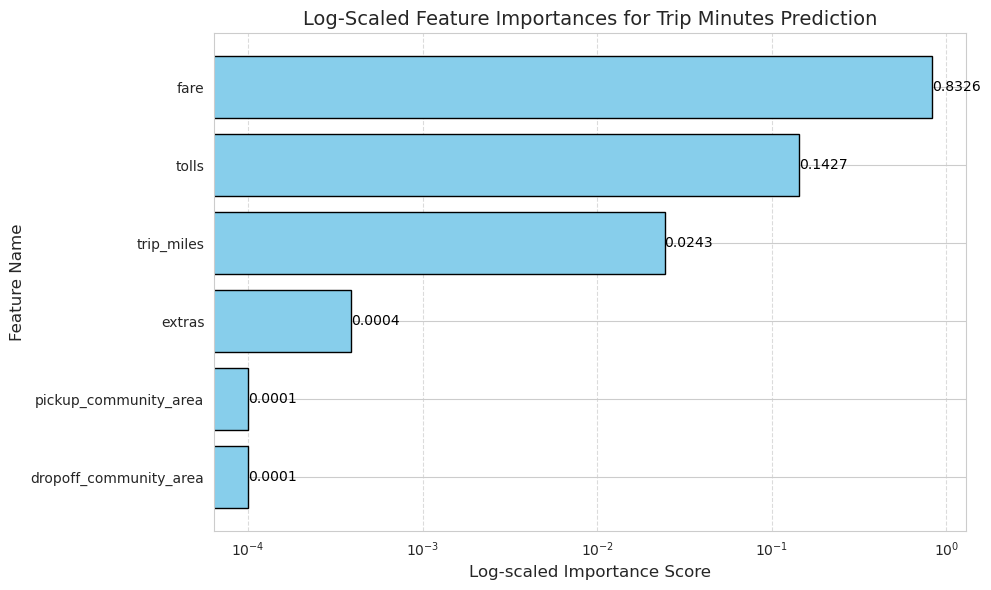

In [213]:
sorted_features = sorted(feature_importance_map.items(), key=lambda x: x[1], reverse=True)
features, importances = zip(*sorted_features)
adjusted_importances = [max(imp, 1e-4) for imp in importances]  

plt.figure(figsize=(10, 6))
bars = plt.barh(features, adjusted_importances, color='skyblue', edgecolor='black')

plt.xscale('log')
for bar, imp in zip(bars, adjusted_importances):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'{imp:.4f}', va='center', ha='left', fontsize=10, color='black')

plt.xlabel('Log-scaled Importance Score', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)
plt.title('Log-Scaled Feature Importances for Trip Minutes Prediction', fontsize=14)
plt.gca().invert_yaxis()  
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Feature Importance Significance

Feature importance quantifies the contribution of each feature to the model's predictive performance. In the output:

- fare (0.8326): This feature dominates, indicating that the fare is a proxy for trip duration. Longer trips often have higher fares, encompassing factors like trip distance and waiting time. Its strong weight suggests fare effectively captures variability in trip durations.
- tolls (0.1427): Tolls reflect highway usage, implying trips involving tolls tend to differ from non-toll trips in duration. Its contribution is notable but significantly less than that of fare.
- trip_miles (0.0243): Though trip miles directly relate to distance traveled, its lower importance indicates that the model relies more on fare, which aggregates multiple trip characteristics, to estimate duration.
- extras (0.0004): Extras, such as additional charges, make a minimal contribution. These charges likely correlate weakly with trip duration, as they depend on specific circumstances (e.g., airport fees)
- pickup_community_area and dropoff_community_area (0.0001 each): These features have negligible influence. This may reflect that community area alone does not sufficiently capture traffic or travel patterns affecting duration, especially compared to direct metrics like fare and tolls

### Hyperparameter Tuning 

Hyperparameters are the external configuration settings of a machine learning model that are not learned from the data but are set prior to training. They control aspects of the learning process, such as model complexity, learning rate, or the number of iterations, and directly impact the model's performance and efficiency.

- maxDepth: This parameter controls the maximum depth of each decision tree in the GBT model. A smaller depth (e.g., 3) results in simpler trees that are less likely to overfit, while a larger depth (e.g., 5) allows the model to capture more complex patterns in the data. By testing multiple values, the goal is to balance model complexity and performance.

- maxIter: This defines the number of boosting iterations or decision trees the model will train sequentially. A higher number (e.g., 15) generally improves the model's ability to minimize errors but increases computation time and the risk of overfitting. Testing values (e.g., 10, 15) helps identify the optimal trade-off between performance and efficiency.

- stepSize: This parameter specifies the learning rate, determining the contribution of each tree to the final model. A smaller value (e.g., 0.05) ensures gradual learning, reducing the risk of overfitting while maintaining model stability.


In [220]:
from pyspark.ml.tuning import ParamGridBuilder

param_grid = (ParamGridBuilder()
              .addGrid(gbt_regressor.maxDepth, [2, 5])  
              .addGrid(gbt_regressor.maxIter, [10, 15])  
              .addGrid(gbt_regressor.stepSize, [0.05])  
              .build())



### Cross Validation


Cross-validation divides the dataset into several folds, training the model on a subset and validating it on the remaining data in each iteration. Here, a 3-fold cross-validation splits the data into three parts, ensuring each fold is used once for validation. This approach provides a robust estimate of model performance by reducing the impact of data splits or randomness.


In [222]:
from pyspark.ml.tuning import CrossValidator

crossval = CrossValidator(estimator=pipeline, 
                          estimatorParamMaps=param_grid, 
                          evaluator=evaluator, 
                          numFolds=3)
cv_model = crossval.fit(train_data)
cv_prediction = cv_model.transform(test_data)
rmse_cv = evaluator.evaluate(cv_prediction)
print(f"Post Cross Validation Root Mean Squared Error (RMSE): {rmse_cv}")

24/12/03 17:13:59 WARN CacheManager: Asked to cache already cached data.
24/12/03 17:13:59 WARN CacheManager: Asked to cache already cached data.


Post Cross Validation Root Mean Squared Error (RMSE): 0.35951434124312986


### Comparison of RMSE Values



- Initial RMSE: 0.3595
- Post-Cross Validation RMSE: 0.3595 (approximately the same: 0.35951434124312986)

The RMSE remains effectively unchanged before and after cross-validation, signifying that the original hyperparameters were already well-tuned for this dataset. Cross-validation provided validation for the stability of the model's performance and confirmed that it generalizes well without significant overfitting or underfitting.


### Post Cross Validation Feature Importance 

In [225]:
cv_gbt_model = cv_model.bestModel.stages[-1]  

feature_importances = cv_gbt_model.featureImportances
feature_names = assembler.getInputCols()
feature_importance_pairs = list(zip(feature_names, feature_importances.toArray()))
sorted_importances = sorted(feature_importance_pairs, key=lambda x: -x[1])
cv_df_importance = pd.DataFrame(sorted_importances, columns=["Feature", "Importance"])
print(cv_df_importance.to_string(index=False))


               Feature  Importance
                  fare        0.90
                 tolls        0.07
            trip_miles        0.03
                extras        0.00
 pickup_community_area        0.00
dropoff_community_area        0.00


### Post Cross Validation Feature Importance Plot

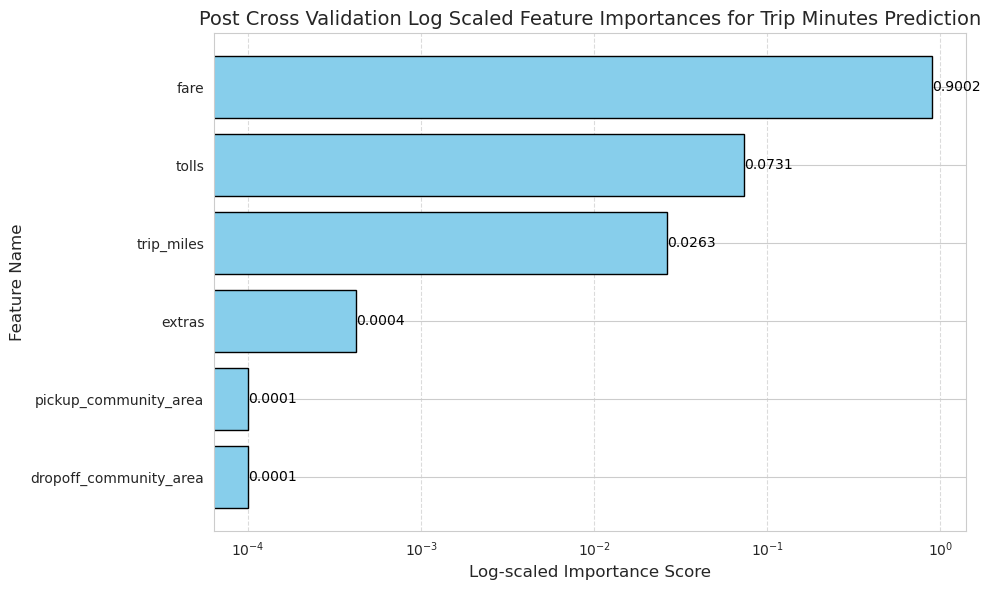

In [224]:
sorted_features, sorted_importances = zip(*sorted_importances)
adjusted_importances = [max(imp, 1e-4) for imp in sorted_importances]  # Avoiding exact zero

plt.figure(figsize=(10, 6))
bars = plt.barh(sorted_features, adjusted_importances, color='skyblue', edgecolor='black')

plt.xscale('log')

for bar, imp in zip(bars, adjusted_importances):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f'{imp:.4f}', va='center', ha='left', fontsize=10, color='black')

plt.xlabel('Log-scaled Importance Score', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)
plt.title('Post Cross Validation Log Scaled Feature Importances for Trip Minutes Prediction', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


The analysis demonstrated that the Gradient Boosted Trees Regressor model effectively predicts taxi trip durations, with a consistent RMSE of 0.3595 before and after cross-validation, indicating strong generalization and minimal overfitting or underfitting. Feature importance analysis revealed that fare is the dominant predictor, increasing in importance from 83.26% to 90.02% post-cross-validation, likely due to its strong correlation with trip distance and duration. Tolls showed reduced importance (from 14.27% to 7.31%), reflecting their moderate role in capturing highway-related travel characteristics. Secondary features like trip miles and extras maintained consistent but minor contributions, while pickup and dropoff community areas remained negligible, adding little value to predictions. Hyperparameter tuning refined the model’s understanding of feature contributions without significant changes to performance, validating its robustness. These results highlight fare and tolls as key predictors while confirming the model’s reliability and interpretability.



## 9. Conclusion, Challenges, and Future Scope<a class="anchor" id="9"></a>
---

### 9.1 Conclusion
The analysis of Chicago taxi trips reveals distinct trends in taxi usage across various timeframes. A significant disparity emerges in the volume of taxi rides between downtown Chicago, Chicago O’Hare International Airport, and other areas of the city, highlighting potential hotspots for traffic congestion. This is also supported by the lower average speed in the Downtown area when compared to other areas. For Chicago O'Hare International Airport, however, the average speed is moderately high compares to over area, which indicate that the traffic is not severe due to the presence of a tollway. Demand is consistently high on weekdays throughout Chicago and across the years, peaking around 5PM as commuters leave work.

There are some unpredictability in the years following COVID-lockdown. The number of taxi rides and taxi cars drop significantly. However, when compare the traffic by month and by day of week within the same year, there is not much change in that traffic is especially bad during the rush hour before and after work, and on weekdays.

Overall, this analysis provides insights into areas and time where the traffic condition is especially bad when compared to other area across Chicago, identifying areas where more public transportation should be increased to reduce the time spent on the roads.

### 9.2 Challenges
1. **Data Quality:** Some features of the data contains values that are either unrealistics or unintuitive to what they represent. We make decisions to either drop the rows or impute thevalues keeping in mind the amount of data that may be lost.
2. **Missing Data:** Some essential columns have missing data, such as trip_miles and trip_seconds. We compare the number of missing values to the whole dataset and find that it is a very small percentage. We decide to drop those rows.
3. **Visualization Choice:** The amount of data that we are analyzing make it difficult to be visualized fully in a plot. Most of the plots we show in this notebook are aggregated data that is easier to display and derived meanings from.
4. **Collaboration:** We use Google Cloud Dataproc for its parallel computing power, but the shared environment makes it difficult for different team members to work simultaneously.

### 9.3 Future Scope
Future analysis on the Chicago taxi trip dataset should explore a more comprehensive way to determine traffic based on route taken instead of pickup and dropoff community area because this doesn't account for the community areas that the trip drives pass to get to the destination. The overall travel time could be heavily impact by the traffic conditions in individual community areas along the route. However, this is an issue that must be addressed by the dataset's publisher since we cannot determine the route taken by simply looking at the current dataset.

## 10. References and Generative AI Disclosure<a class="anchor" id="10"></a>
---
### Reference
1. https://spark.apache.org/docs/latest/api/python/index.html
2. https://spark.apache.org/docs/latest/api/python/reference/pyspark.ml.html

### Generative AI Disclosure
#### Code Review and Debugging
We use ChatGPT to suggest ways to improve our Python code, including optimizing algorithms and resolving potential errors.

#### Content Generation
We used ChatGPT to brainstorm ideas and structure the initial outline of the project. The AI helped us refine our thesis statement and suggested key points to include in each section.